### Install and Import Packages

In [18]:
%pip install spuco
%pip install wandb
%pip install fast_pytorch_kmeans
%pip install simclr

In [19]:
!git clone https://github.com/Spijkervet/SimCLR.git

!pip install git+https://github.com/openai/CLIP.git

fatal: destination path 'SimCLR' already exists and is not an empty directory.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xxyhmu5j
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xxyhmu5j
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [20]:

import argparse
import os
import pickle
from datetime import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from spuco.robust_train import ERM
from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty, SpuriousTargetDatasetWrapper
import torchvision.transforms as T
import numpy as np
# import sas.subset_dataset
from spuco.evaluate import Evaluator
import torch
import torch.multiprocessing as mp
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.distributed import destroy_process_group, init_process_group
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
import wandb
import torchvision
from torchvision.models import resnet18
from torchvision import transforms

# from configs import SupportedDatasets, get_datasets
# from projection_heads.critic import LinearCritic
# from resnet import *
# from trainer import Trainer
# from util import Random

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [22]:
from spuco.utils import set_seed
set_seed(0)

### Mount GDrive

In [23]:
import os
try:

    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    DRIVE_PATH = '/content/drive/'
    DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
    if not os.path.exists(DRIVE_PYTHON_PATH):
      %mkdir $DRIVE_PATH

    ## the space in `My Drive` causes some issues,
    ## make a symlink to avoid this
    SYM_PATH = '/content/drive/My Drive/'
    if not os.path.exists(SYM_PATH):
      !ln -s $DRIVE_PATH $SYM_PATH

    running_in_colab = True

    # We already mounted in our google drive.
    # Enter the foler where you put files in:
    %cd '/content/drive/My Drive/'

    # Current working directory:
    !pwd

    # What files are there:
    !ls


except ModuleNotFoundError:
    running_in_colab = False
    print(
        "I guess you are running locally. If you get this message in Colab, check the files."
    )


Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive
 01.DQN.ipynb
'Affirmations Positive Content.gdoc'
'AIDS Case Study  Botswana..gdoc'
'Anthony Hard Campaigning Sign up Sheet.gsheet'
'Arabian Nights Openings.gdoc'
'Arjun Perf Feedback April 2023.gdoc'
 assignment3.ipynb
 assignment3_my_copy
 assignment4
 assignment_4_results
'Australian Population Distribution Case Study.gdoc'
 Berkeley_SOP.gdoc
 Berkeley_SOP.pdf
'BigML Lab Application.gdoc'
'bina photos.zip'
'bina recipes'
'Blurb for Alphabet - send to Sahil.gdoc'
'Blurb on Divyansh for Sirej.gdoc'
'Bolei Zhou e-mail.gdoc'
'Book Summaries'
 Budgeting.gsheet
'Calories Chart.gsheet'
'Career Advice'
'CD Interpretation Research Plan.gdoc'
'Changes to Interview - Divyansh.gdoc'
'CITRIS Mobile App Challenge Application.gdoc'
 Classroom
 ClimateLearn
'ClimateLearn Paper Summary.gdoc'
'CLIP paper.gdoc'
'CMU SOP (1).gdoc'
'CMU SOP - Final.gdoc'
'CMU SOP.gdoc'
'Colab Notebooks'
'COM 19 Interpersonal Dynamics Goal Setting

### Get SpuCoMNIST Dataset

In [24]:
classes = [[0],[1],[2],[3],[4]]
difficulty = [SpuriousFeatureDifficulty.VARIANCE_HIGH,SpuriousFeatureDifficulty.VARIANCE_MEDIUM,SpuriousFeatureDifficulty.VARIANCE_LOW]
corr_strngth = [0.3,0.6,0.9,0.99]
mp = {}
mp[difficulty[0]] = 'high'
mp[difficulty[1]] = 'medium'
mp[difficulty[2]] = 'low'

In [25]:
# NOTE: CHANGE THESE PARAMETERS AS PER THE REQUIREMENTS OF
# THE EXPERIMENT
D = difficulty[0]
C = corr_strngth[2]

In [26]:
def preprocess_data(dataset):
    embed_transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.ToTensor(),
    ])
    train_set = [embed_transform(i[0].resize(3,28,28)) for i in dataset]
    label_dict = {value: key for key, values in dataset.group_partition.items() for value in values}
    class_labels,spurious_labels = zip(*[label_dict[i] for i in range(len(dataset))])

    return train_set,class_labels,spurious_labels, label_dict

def get_data_for_curr_configs(D, C):
    curr_trainset = SpuCoMNIST(
            root="/data/mnist/",
            spurious_feature_difficulty=D,
            spurious_correlation_strength=C,
            classes=classes,
            split="train",
            label_noise=0.001
        )
    curr_trainset.initialize()


    curr_testset = SpuCoMNIST(
        root="/data/mnist/",
        spurious_feature_difficulty=D,
        classes=classes,
        split="test"
    )


    curr_testset.initialize()

    curr_valset = SpuCoMNIST(
        root="/data/mnist/",
        spurious_feature_difficulty=D,
        classes=classes,
        split="val"
    )

    curr_valset.initialize()

    return curr_trainset, curr_testset, curr_valset

In [27]:
curr_trainset, curr_testset, curr_valset = get_data_for_curr_configs(D, C)

train_set,train_clabels,train_slabels, train_label_dict = preprocess_data(curr_trainset)
test_set,test_clabels,test_slabels, test_label_dict = preprocess_data(curr_testset)
val_set,val_clabels,val_slabels, val_label_dict = preprocess_data(curr_valset)

100%|██████████| 11996/11996 [00:02<00:00, 5052.08it/s]


In [28]:
train_set1 = torch.stack(train_set[0:12032],dim=0)
train_set2 = torch.stack(train_set[12032:24064],dim=0)


val_set1 = torch.stack(val_set[0:2560],dim=0)
val_set2 = torch.stack(val_set[2560:5120],dim=0)

In [29]:
strainset = SpuriousTargetDatasetWrapper(curr_trainset,train_slabels)
stestset = SpuriousTargetDatasetWrapper(curr_testset,test_slabels)

### Train SimCLR and Downstream Linear Classifier

In [13]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(14),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        img = self.dataset[index]
        img1 = train_transform(img)
        img2 = train_transform(img)
        return img1, img2

    def __len__(self):
        return len(self.dataset)

class LinearClassifier(torch.nn.Module):
    def __init__(self, input_size,output_size,hidden_size=32):
        super(LinearClassifier, self).__init__()
        self.projection_head = torch.nn.Sequential(
              # torch.nn.Linear(input_size,hidden_size),
              # torch.nn.ReLU(),
              torch.nn.Linear(input_size,output_size)
          )

    def forward(self, x):
        return self.projection_head(x)


!cd SimCLR
from simclr import SimCLR
from simclr.modules import get_resnet, NT_Xent

def custom_train_simclr(train_set, batch_size=512, num_epochs=50, simclr_model=None):
    """NOTE: training on subset selected by SAS might require
        a custom batch_size, if the subet is smaller than the default batch size"""


    max_index_range = batch_size * (len(train_set)//batch_size)
    aug_x_train = SimCLRDataset(train_set[0:max_index_range])
    dataloader = DataLoader(aug_x_train, batch_size=batch_size, shuffle=True)

    encoder = get_resnet("resnet18").to(device)
    # for param in encoder.parameters():
    #     param.requires_grad = False
    projection_dim = 16
    n_features = encoder.fc.in_features  # get dimensions of last fully-connected layer
    if simclr_model is None:
        simclr_model = SimCLR(encoder, projection_dim, n_features).to(device)

    encoder = encoder.to('cpu')
    simclr_model = simclr_model.to('cuda')

    temperature=0.05
    world_size=1
    simclr_criterion = NT_Xent(batch_size, temperature, world_size)
    simclr_optimizer = optim.Adam(simclr_model.parameters(), lr=1e-3)
    # Training loop
    simclr_model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for x1, x2 in dataloader:
            # print(x1.shape)
            x1, x2 = x1.to(device), x2.to(device)
            simclr_optimizer.zero_grad()
            h1,h2,z1,z2= simclr_model(x1,x2)
            loss = simclr_criterion(z1, z2)
            loss.backward()
            simclr_optimizer.step()
            total_loss += loss.item()
        total_loss = total_loss/len(dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

    return simclr_model


def get_simclr_embeddings(simclr_model, data_set):
    """ So far, we have been using data_set = val_set"""

    #x_set1 = torch.stack(data_set[0:max_index],dim=0)
    #x_set2 = torch.stack(data_set[max_index:],dim=0)
    x_set = torch.stack(data_set[:], dim=0)
    simclr_model.eval()
    x_set = x_set.to(device)
    _,_,_,x_embed = simclr_model(x_set,x_set)
    x_set.to(torch.device("cpu"))
    #x_embed = torch.stack([x_embed1,x_embed2],dim=0).detach()
    #x_embed = x_embed.reshape(-1,16)
    print(x_embed.shape)
    return x_embed

def get_simclr_embeddings_big_dataset(simclr_model, data_set1, data_set2, embed_dim=16):
    """ Use for train_set. Set data_set1 = train_set1 and data_set2 = train_set2.
        If you use get_simclr_embeddings instead of this function, you will
        get OOM errors.
    """


    simclr_model.eval()
    _,_,x_embed1, x_embed2 = simclr_model(data_set1.to(device),data_set2.to(device))
    x_embed = torch.stack([x_embed1,x_embed2],dim=0).detach()
    x_embed = x_embed.reshape(-1,embed_dim)
    print(x_embed.shape)
    return x_embed


def train_linear_classifier(x_embed, labels, num_epochs=10000):
    classifier = LinearClassifier(16,5).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

    classifier.train()
    for epoch in range(num_epochs):
        # Forward pass
        outputs = classifier(x_embed.to(device))
        loss = criterion(outputs,torch.tensor(labels).to(device))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{100}, Loss: {loss.item()}')

    return classifier


from sklearn.metrics import confusion_matrix

def pred_acc(emd_model,clf_model,x_data,y_data):
    _,_,_,x_embed = emd_model(x_data.to(device),x_data.to(device))
    x_embed = x_embed.detach()
    predictions = clf_model(x_embed.to(device))
    print("predictions.size(): ", predictions.size())
    predicted_classes = torch.argmax(predictions, dim=1)
    print("predicted_classes.size(): ", predicted_classes.size())
    actual_classes = torch.tensor(y_data).to(device)
    accuracy = torch.sum(predicted_classes == actual_classes).item() / len(actual_classes)
    cfm = confusion_matrix(predicted_classes.cpu().numpy(), actual_classes.cpu().numpy())
    class_accuracies = np.diag(cfm) / np.sum(cfm, axis=0)
    return accuracy,cfm,class_accuracies,np.min(class_accuracies)


from torch.utils.data import Dataset

class EmbeddingsDataset(Dataset):
    def __init__(self, x_data, labels, emd_model, group_partition):
        self.x_data = x_data
        self.labels = np.array(labels)
        self.emd_model = emd_model
        self.group_partition = group_partition

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #curr_x_data = self.x_data[idx].resize(1, 3, 28, 28)
        #_,_,_,x_embed = self.emd_model(curr_x_data.to(device),curr_x_data.to(device))
        #x_embed = x_embed.detach()

        #print(self.labels[idx])
        return self.x_data[idx], self.labels[idx]


import collections

def get_group_partition_for_selected_subset(indices,dct):
    """
    indices: set of indices for the selected subset
    dct: dictionary mapping indices to groups
    """
    selected_test_group_partition = collections.defaultdict(list)
    for i in indices:
        group_label = dct[i]
        selected_test_group_partition[group_label].append(i)
    return selected_test_group_partition

def get_group_wise_accuracy(simclr_sas_embeddings, classifier, test_set, trainset, evaluate_on_color=False):
    """NOTE: trainset is what we directly get from SpuCoMNIST. It is not
     the processed train_set we later compute"""

    labels = test_clabels
    if evaluate_on_color:
        labels = test_slabels
    x_embed = simclr_sas_embeddings.to(torch.device("cpu"))#.detach()
    test_embeddings_dataset = EmbeddingsDataset(x_embed,labels, None,
                                                get_group_partition_for_selected_subset(np.arange(x_embed.shape[0]), test_label_dict))


    evaluator = Evaluator(
        testset=test_embeddings_dataset,
        group_partition=test_embeddings_dataset.group_partition,
        group_weights=trainset.group_weights,
        batch_size=64,
        model=classifier.to(torch.device("cpu")),
        device=torch.device("cpu"),
        verbose=True
    )
    group_wise_accs = evaluator.evaluate()
    print(" ")
    print("average accuracy: ", evaluator.average_accuracy)
    print("worst-group accuracy: ", evaluator.worst_group_accuracy)

    return group_wise_accs

def get_group_wise_accuracy_on_colors(simclr_sas_embeddings, classifier, test_set, trainset):
    """NOTE: trainset is what we directly get from SpuCoMNIST. It is not
     the processed train_set we later compute"""

    x_embed = simclr_sas_embeddings.to(torch.device("cpu"))#.detach()
    test_embeddings_dataset = EmbeddingsDataset(x_embed,test_slabels, None,
                                                get_group_partition_for_selected_subset(np.arange(x_embed.shape[0]), test_label_dict))


    evaluator = Evaluator(
        testset=test_embeddings_dataset,
        group_partition=test_embeddings_dataset.group_partition,
        group_weights=trainset.group_weights,
        batch_size=64,
        model=classifier.to(torch.device("cpu")),
        device=torch.device("cpu"),
        verbose=True
    )
    group_wise_accs = evaluator.evaluate()
    print(" ")
    print("average accuracy: ", evaluator.average_accuracy)
    print("worst-group accuracy: ", evaluator.worst_group_accuracy)

    return group_wise_accs

In [ ]:
500/len(curr_trainset)

0.020425670983291802

In [ ]:
# Train SimCLR model
# Uncomment Lines in this Cell to Train a SimCLR model

#simclr_model = custom_train_simclr(train_set)

#fname = 'simclr_'+mp[D]+'_'+str(C)+'.pkl'
#torch.save(simclr_model,fname)

In [ ]:
fname = 'simclr_'+mp[D]+'_'+str(C)+'.pkl'
simclr_model = torch.load(fname)

#### Train Linear Classifier on Small, Balanced Subset

In [ ]:
simclr_model.eval()
_,_,val_embed1,val_embed2 = simclr_model(val_set1.to(device),val_set2.to(device))
val_embed = torch.stack([val_embed1,val_embed2],dim=0).detach()
val_embed = val_embed.reshape(-1,16)
print(val_embed.shape)

torch.Size([5120, 16])


In [ ]:
classifier_on_raw_trainset = train_linear_classifier(val_embed, val_clabels[:5120])

Epoch 100/100, Loss: 2.127830982208252
Epoch 200/100, Loss: 1.4091975688934326
Epoch 300/100, Loss: 1.1992552280426025
Epoch 400/100, Loss: 1.0966321229934692
Epoch 500/100, Loss: 1.0295273065567017
Epoch 600/100, Loss: 0.9831336736679077
Epoch 700/100, Loss: 0.9510201215744019
Epoch 800/100, Loss: 0.9280635714530945
Epoch 900/100, Loss: 0.9108352661132812
Epoch 1000/100, Loss: 0.8972991704940796
Epoch 1100/100, Loss: 0.8862641453742981
Epoch 1200/100, Loss: 0.8770130276679993
Epoch 1300/100, Loss: 0.8690959215164185
Epoch 1400/100, Loss: 0.8622173070907593
Epoch 1500/100, Loss: 0.8561738729476929
Epoch 1600/100, Loss: 0.8508198857307434
Epoch 1700/100, Loss: 0.846044659614563
Epoch 1800/100, Loss: 0.8417617678642273
Epoch 1900/100, Loss: 0.83790123462677
Epoch 2000/100, Loss: 0.8344049453735352
Epoch 2100/100, Loss: 0.8312240839004517
Epoch 2200/100, Loss: 0.8283165693283081
Epoch 2300/100, Loss: 0.8256471753120422
Epoch 2400/100, Loss: 0.8231844902038574
Epoch 2500/100, Loss: 0.82090

#### Get Metrics and Group-Wise Accuracy

In [ ]:
simclr_embeddings_test = get_simclr_embeddings(simclr_model, test_set)

get_group_wise_accuracy(simclr_embeddings_test,
                        classifier_on_raw_trainset,
                        test_set,
                        curr_trainset)

get_group_wise_accuracy(simclr_embeddings_test,
                        classifier_on_raw_trainset,
                        test_set,
                        curr_trainset,
                        evaluate_on_color=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([5139, 16])


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:06,  3.55it/s]

Group (0, 0) Accuracy: 55.10204081632653


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:06,  3.63it/s]

Group (0, 1) Accuracy: 70.91836734693878


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:00<00:06,  3.54it/s]

Group (0, 2) Accuracy: 46.93877551020408


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:05,  3.58it/s]

Group (0, 3) Accuracy: 59.69387755102041


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:05,  3.58it/s]

Group (0, 4) Accuracy: 53.57142857142857


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:01<00:05,  3.52it/s]

Group (1, 0) Accuracy: 96.0352422907489


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:01<00:05,  3.52it/s]

Group (1, 1) Accuracy: 94.7136563876652


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:02<00:04,  3.52it/s]

Group (1, 2) Accuracy: 94.7136563876652


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:02<00:04,  3.57it/s]

Group (1, 3) Accuracy: 96.0352422907489


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:02<00:04,  3.53it/s]

Group (1, 4) Accuracy: 94.7136563876652


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:03<00:03,  3.54it/s]

Group (2, 0) Accuracy: 76.32850241545894


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:03<00:03,  3.56it/s]

Group (2, 1) Accuracy: 68.59903381642512


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:03<00:03,  3.53it/s]

Group (2, 2) Accuracy: 74.75728155339806


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:03<00:03,  3.53it/s]

Group (2, 3) Accuracy: 84.95145631067962


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:04<00:02,  3.58it/s]

Group (2, 4) Accuracy: 78.64077669902913


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:04<00:02,  3.67it/s]

Group (3, 0) Accuracy: 12.871287128712872


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:04<00:02,  3.75it/s]

Group (3, 1) Accuracy: 9.900990099009901


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:05<00:01,  3.65it/s]

Group (3, 2) Accuracy: 33.16831683168317


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:05<00:01,  3.65it/s]

Group (3, 3) Accuracy: 32.67326732673267


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:05<00:01,  3.68it/s]

Group (3, 4) Accuracy: 31.683168316831683


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:05<00:01,  3.67it/s]

Group (4, 0) Accuracy: 59.390862944162436


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:06<00:00,  3.63it/s]

Group (4, 1) Accuracy: 45.17766497461929


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:06<00:00,  3.69it/s]

Group (4, 2) Accuracy: 59.69387755102041


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:06<00:00,  3.72it/s]

Group (4, 3) Accuracy: 72.44897959183673


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:06<00:00,  3.61it/s]


Group (4, 4) Accuracy: 67.85714285714286
 
average accuracy:  65.33402679237442
worst-group accuracy:  ((3, 1), 9.900990099009901)


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:06,  3.79it/s]

Group (0, 0) Accuracy: 55.10204081632653


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:05,  3.86it/s]

Group (0, 1) Accuracy: 2.5510204081632653


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:00<00:05,  3.83it/s]

Group (0, 2) Accuracy: 19.387755102040817


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:05,  3.76it/s]

Group (0, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:05,  3.75it/s]

Group (0, 4) Accuracy: 33.16326530612245


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:01<00:05,  3.76it/s]

Group (1, 0) Accuracy: 2.202643171806167


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:01<00:04,  3.70it/s]

Group (1, 1) Accuracy: 94.7136563876652


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:02<00:04,  3.63it/s]

Group (1, 2) Accuracy: 1.3215859030837005


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:02<00:04,  3.67it/s]

Group (1, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:02<00:04,  3.40it/s]

Group (1, 4) Accuracy: 3.0837004405286343


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:03<00:04,  2.99it/s]

Group (2, 0) Accuracy: 14.97584541062802


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:03<00:04,  2.74it/s]

Group (2, 1) Accuracy: 2.4154589371980677


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:04<00:04,  2.57it/s]

Group (2, 2) Accuracy: 74.75728155339806


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:04<00:04,  2.46it/s]

Group (2, 3) Accuracy: 2.4271844660194173


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:04<00:04,  2.37it/s]

Group (2, 4) Accuracy: 8.737864077669903


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:05<00:03,  2.36it/s]

Group (3, 0) Accuracy: 3.4653465346534653


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:05<00:03,  2.32it/s]

Group (3, 1) Accuracy: 2.9702970297029703


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:06<00:02,  2.34it/s]

Group (3, 2) Accuracy: 59.9009900990099


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:06<00:02,  2.31it/s]

Group (3, 3) Accuracy: 32.67326732673267


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:07<00:02,  2.25it/s]

Group (3, 4) Accuracy: 1.4851485148514851


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:07<00:01,  2.27it/s]

Group (4, 0) Accuracy: 27.918781725888326


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:08<00:01,  2.33it/s]

Group (4, 1) Accuracy: 15.228426395939087


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:08<00:00,  2.51it/s]

Group (4, 2) Accuracy: 6.63265306122449


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:08<00:00,  2.77it/s]

Group (4, 3) Accuracy: 0.0


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:08<00:00,  2.81it/s]

Group (4, 4) Accuracy: 67.85714285714286
 
average accuracy:  60.031615794533856
worst-group accuracy:  ((0, 3), 0.0)


{(0, 0): 55.10204081632653,
 (0, 1): 2.5510204081632653,
 (0, 2): 19.387755102040817,
 (0, 3): 0.0,
 (0, 4): 33.16326530612245,
 (1, 0): 2.202643171806167,
 (1, 1): 94.7136563876652,
 (1, 2): 1.3215859030837005,
 (1, 3): 0.0,
 (1, 4): 3.0837004405286343,
 (2, 0): 14.97584541062802,
 (2, 1): 2.4154589371980677,
 (2, 2): 74.75728155339806,
 (2, 3): 2.4271844660194173,
 (2, 4): 8.737864077669903,
 (3, 0): 3.4653465346534653,
 (3, 1): 2.9702970297029703,
 (3, 2): 59.9009900990099,
 (3, 3): 32.67326732673267,
 (3, 4): 1.4851485148514851,
 (4, 0): 27.918781725888326,
 (4, 1): 15.228426395939087,
 (4, 2): 6.63265306122449,
 (4, 3): 0.0,
 (4, 4): 67.85714285714286}

In [ ]:
num_same = 0
for x, y in zip(test_clabels, test_slabels):
    if x == y:
        num_same += 1
    print(x, y)

Streaming output truncated to the last 5000 lines.
0 1
3 0
0 3
1 1
4 3
1 2
2 0
1 1
2 1
2 4
4 4
1 4
2 1
2 1
0 0
4 2
0 3
0 3
2 3
4 3
1 4
2 3
4 1
0 2
2 1
4 4
3 4
3 4
0 1
0 2
3 1
1 1
2 1
2 0
3 1
0 1
4 0
2 3
0 4
1 3
1 3
2 1
1 3
3 0
3 4
1 4
3 2
1 1
0 0
1 2
3 4
1 3
1 0
1 1
4 3
2 3
2 0
0 0
3 4
2 3
0 4
4 0
1 0
1 4
4 2
0 0
3 4
3 3
1 4
2 0
1 3
2 3
1 1
2 2
4 1
4 4
2 4
3 3
2 3
4 2
0 2
3 1
1 0
1 0
2 3
1 0
4 4
2 2
2 4
0 1
4 1
1 0
4 1
1 2
4 4
3 2
0 0
0 2
3 1
0 0
2 0
4 4
3 1
3 2
3 2
2 4
3 0
1 4
2 4
0 1
3 0
2 0
1 2
4 2
1 3
2 2
1 3
4 3
0 3
1 0
0 3
2 2
3 0
4 1
0 2
3 3
2 1
1 4
3 0
1 2
3 4
4 0
2 4
2 4
3 1
2 4
4 1
1 2
3 3
0 0
3 2
3 0
1 0
3 3
4 0
4 4
4 4
2 0
1 0
2 1
4 0
4 4
0 3
0 3
2 0
3 0
2 0
0 1
4 4
4 3
0 0
0 1
4 4
0 1
3 1
4 3
3 4
3 4
3 1
3 3
3 1
0 1
2 1
1 0
0 3
4 1
3 2
0 4
3 2
0 3
0 2
2 1
4 0
0 1
2 3
2 0
3 0
1 3
1 4
0 3
4 3
2 4
3 3
2 1
2 4
2 4
2 4
3 3
1 4
0 1
2 2
0 2
2 4
1 0
3 1
1 3
2 3
0 2
3 0
2 2
4 0
0 4
1 3
4 2
3 3
4 1
1 3
1 2
3 1
1 4
3 2
3 0
3 0
2 2
1 2
1 2
4 1
4 3
3 1
1 0
0 2
0 4
4 2
4 1
4 3
0 2
2 3
1

In [ ]:
num_same/len(test_clabels) * 100


0.1998443276902121

### T-SNE Visualization

In [30]:
def get_tsne_embeddings(simclr_model, set1=None, set2=None, x_embed=None, get_embedding = True, embedding_dim=16, is_proxy=False):
    if get_embedding:
        assert set1 is not None and set2 is not None
    else:
        assert x_embed is not None

    if get_embedding:
        if is_proxy:
            x_embed1 = simclr_model(set1.to(device))
            x_embed2 = simclr_model(set2.to(device))
        else:
            _,_,x_embed1,x_embed2 = simclr_model(set1.to(device),set2.to(device))
        x_embed = torch.stack([x_embed1,x_embed2],dim=0).detach()
        x_embed = x_embed.reshape(-1,embedding_dim)
    print(x_embed.shape)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=50)
    X_tsne = tsne.fit_transform(x_embed.cpu().numpy())
    return X_tsne


def visualize_tsne_embeddings(X_tsne, label_dict, indices_for_group_partition=np.arange(24064),
                              title='t-SNE visualization of embeddings from SimCLR Trained on \n Full Training Dataset (Variance = {}, Correlation={})'.format(
                                                mp[D], C
                              )):
    """
       X_tsne: Embeddings generated by T-SNE
       label_dict: See section in the beginning of the notebook where we get the train_set, val_set, etc.
       indices_range = np.arange(0, size of dataset considered)
    """
    find_actual_indices = False
    if X_tsne.shape[0] < len(train_label_dict):
        find_actual_indices = True

    # Plot the results
    plt.figure(figsize=(8, 6))

    curr_set_group_partition = get_group_partition_for_selected_subset(indices_for_group_partition,label_dict)

    colors = ['red', 'green', 'blue', "yellow", "black"]
    for group, indices in curr_set_group_partition.items():
        actual_indices = indices
        if find_actual_indices:
            actual_indices = [indices_for_group_partition.index(idx) for idx in indices]
        c = colors[group[0]]
        plt.scatter(X_tsne[actual_indices, 0], X_tsne[actual_indices, 1], c=c,
                    label=str(group[0]), alpha=0.2)


    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.title(title)
    plt.show()

In [ ]:
len(train_label_dict)

24479

torch.Size([24064, 16])


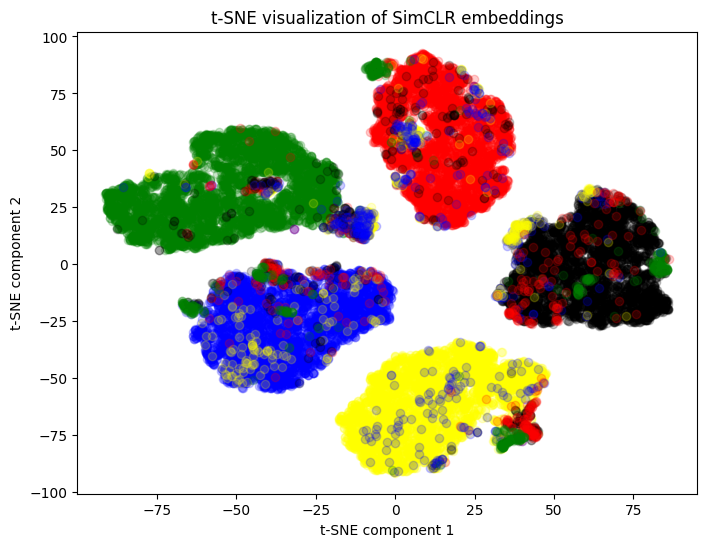

In [ ]:

X_tsne = get_tsne_embeddings(simclr_model, train_set1, train_set2)

visualize_tsne_embeddings(X_tsne, train_label_dict)

### SAS

#### Scripts Copied From SAS Package (Uncollapse this section and run the cell in it)

In [31]:
from copy import deepcopy
from typing import List

import clip
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from fast_pytorch_kmeans import KMeans
from tqdm import tqdm

def clip_approx(
    img_trainset: torch.utils.data.Dataset,
    labeled_example_indices: List[int],
    labeled_examples_labels: np.array,
    num_classes: int,
    device: torch.device,
    batch_size: int = 512,
    verbose: bool = False,
):
    Z = encode_using_clip(
        img_trainset=img_trainset,
        device=device,
        batch_size=batch_size,
        verbose=verbose
    )
    clf = train_linear_classifier(
        X=Z[labeled_example_indices],
        y=torch.tensor(labeled_examples_labels),
        representation_dim=len(Z[0]),
        num_classes=num_classes,
        device=device,
        verbose=verbose
    )
    preds = []
    for start_idx in range(0, len(Z), batch_size):
        preds.append(torch.argmax(clf(Z[start_idx:start_idx + batch_size]).detach(), dim=1).cpu())
    preds = torch.cat(preds).numpy()

    return partition_from_preds(preds)

def clip_0shot_approx(
    img_trainset: torch.utils.data.Dataset,
    class_names: List[str],
    device: torch.device,
    verbose: bool = False,
):
    model, preprocess = clip.load("ViT-B/32", device=device)
    img_trainset = deepcopy(img_trainset)
    img_trainset.transform = preprocess

    zeroshot_weights = zeroshot_classifier(
        class_names=class_names,
        device=device,
        verbose=verbose
    )
    logits = []
    loader = torch.utils.data.DataLoader(img_trainset, batch_size=32, num_workers=2)
    with torch.no_grad():
        for input in tqdm(loader, "0-shot classification using provided text names for classes", disable=not verbose):
            # predict
            image_features = model.encode_image(input[0].to(device=device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits.append(100. * image_features @ zeroshot_weights)

    preds = []
    for logit in logits:
        preds.append(logit.topk(1, 1, True, True)[1].t()[0])

    return partition_from_preds(preds)

def kmeans_approx(
    trainset: torch.utils.data.Dataset,
    proxy_model: nn.Module,
    num_classes: int,
    device: torch.device,
    verbose: bool = False
):
    proxy_model.eval()
    Z = []
    with torch.no_grad():
        loader = torch.utils.data.DataLoader(trainset, batch_size=32, num_workers=2)
        for input in tqdm(loader, "Encoding data using proxy model provided", disable=not verbose):
            Z.append(proxy_model(input[0].to(device)))
    Z = torch.cat(Z, dim=0).to("cpu")
    kmeans = KMeans(n_clusters=num_classes, mode='euclidean', verbose=int(verbose), max_iter=1000)
    preds = kmeans.fit_predict(Z).cpu().numpy()
    return partition_from_preds(preds)

def encode_using_clip(
        img_trainset: torch.utils.data.Dataset,
        device: torch.device,
        batch_size=512,
        verbose: bool = False,
):
    model, preprocess = clip.load("ViT-B/32", device=device)
    img_trainset = deepcopy(img_trainset)
    img_trainset.transform = preprocess

    loader = torch.utils.data.DataLoader(img_trainset, batch_size=batch_size, num_workers=8)
    Z = []
    with torch.no_grad():
        for input in tqdm(loader, desc="Encoding images using CLIP", disable=not verbose):
            Z.append(model.encode_image(input[0].to(device)))
    Z = torch.cat(Z, dim=0).to(torch.float32)
    return Z

def partition_from_preds(preds):
    partition = {}
    for i, pred in enumerate(preds):
        if pred not in partition:
            partition[pred] = []
        partition[pred].append(i)
    return partition

# def train_linear_classifier(
#     X: torch.tensor,
#     y: torch.tensor,
#     representation_dim: int,
#     num_classes: int,
#     device: torch.device,
#     reg_weight: float = 1e-3,
#     n_lbfgs_steps: int = 500,
#     verbose=False,
# ):
#     if verbose:
#         print('\nL2 Regularization weight: %g' % reg_weight)

#     criterion = nn.CrossEntropyLoss()
#     X_gpu = X.to(device)
#     y_gpu = y.to(device)

#     # Should be reset after each epoch for a completely independent evaluation
#     clf = nn.Linear(representation_dim, num_classes).to(device)
#     clf_optimizer = optim.LBFGS(clf.parameters())
#     clf.train()

#     for _ in tqdm(range(n_lbfgs_steps), desc="Training linear classifier using fraction of labels", disable=not verbose):
#         def closure():
#             clf_optimizer.zero_grad()
#             raw_scores = clf(X_gpu)
#             loss = criterion(raw_scores, y_gpu)
#             loss += reg_weight * clf.weight.pow(2).sum()
#             loss.backward()
#             return loss
#         clf_optimizer.step(closure)
#     return clf

def zeroshot_classifier(
    class_names: List[str],
    device: torch.device,
    verbose: bool = False
):
    templates = [
        'itap of the {}.',
        'a bad photo of the {}',
        'a origami {}.',
        'a photo of the large {}.',
        'a {} in a video game.',
        'art of the {}.',
        'a photo of the small {}.',
    ]

    model, _ = clip.load("ViT-B/32")
    model = model.to(device)

    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(class_names, desc="Creating zero shot classifier", disable=not verbose):
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).to(device) #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1)
    return zeroshot_weights




import heapq

def _heappush_max(heap, item):
    heap.append(item)
    heapq._siftdown_max(heap, 0, len(heap)-1)

def _heappop_max(heap):
    """Maxheap version of a heappop."""
    lastelt = heap.pop()  # raises appropriate IndexError if heap is empty
    if heap:
        returnitem = heap[0]
        heap[0] = lastelt
        heapq._siftup_max(heap, 0)
        return returnitem
    return lastelt

def lazy_greedy(F, V, B):
    """
    Args
    - F: Submodular Objective
    - V: list of indices of columns of Similarity Matrix
    - B: Budget of subset (int)
    """
    sset = []

    order = []
    heapq._heapify_max(order)
    [_heappush_max(order, (F.inc(sset, index), index)) for index in V]

    while order and len(sset) < B:
        el = _heappop_max(order)
        improv = F.inc(sset, el[1])

        #if improv >= 0:
        if not order:
            sset.append(el[1])
            F.add(el[1])
        else:
            top = _heappop_max(order)
            if improv >= top[0]:
                sset.append(el[1])
                F.add(el[1])
            else:
                _heappush_max(order, (improv, el[1]))
            _heappush_max(order, top)
    return sset


from abc import ABC
from typing import Dict, List, Optional
import math
import pickle
import random

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from tqdm import tqdm

"""
Base Subset Dataset (Abstract Base Class)
"""
class BaseSubsetDataset(ABC, Dataset):
    def __init__(
        self,
        dataset: Dataset,
        subset_fraction: float,
        verbose: bool = False
    ):
        """
        :param dataset: Original Dataset
        :type dataset: Dataset
        :param subset_fraction: Fractional size of subset
        :type subset_fraction: float
        :param verbose: verbose
        :type verbose: boolean
        """
        self.dataset = dataset
        self.subset_fraction = subset_fraction
        self.len_dataset = len(self.dataset)
        self.subset_size = int(self.len_dataset * self.subset_fraction)
        self.subset_indices = None
        self.verbose = verbose

    def initialization_complete(self):
        if self.verbose:
            print(f"Subset Size: {self.subset_size}")
            print(f"Discarded {self.len_dataset - self.subset_size} examples")

    def __len__(self):
        return self.subset_size

    def __getitem__(self, index):
        # Get the index for the corresponding item in the original dataset
        original_index = self.subset_indices[index]

        # Get the item from the original dataset at the corresponding index
        original_item = self.dataset[original_index]

        return original_item

    def save_to_file(self, filename):
        with open(filename, "wb") as f:
            pickle.dump(self.subset_indices, f)

"""
Random Subset
"""
class RandomSubsetDataset(BaseSubsetDataset):
    def __init__(
        self,
        dataset: Dataset,
        subset_fraction: float,
        verbose: bool = False
    ):
        """
        :param dataset: Original Dataset
        :type dataset: Dataset
        :param subset_fraction: Fractional size of subset
        :type subset_fraction: float
        :param verbose: verbose
        :type verbose: boolean
        """
        super().__init__(
            dataset=dataset,
            subset_fraction=subset_fraction,
            verbose=verbose
        )
        self.subset_indices = random.sample(range(self.len_dataset), self.subset_size)
        self.initialization_complete()

    def __len__(self):
        return self.subset_size

    def __getitem__(self, index):
        # Get the index for the corresponding item in the original dataset
        original_index = self.subset_indices[index]

        # Get the item from the original dataset at the corresponding index
        original_item = self.dataset[original_index]

        return original_item

"""
Custom Subset
"""
class CustomSubsetDataset(BaseSubsetDataset):
    def __init__(
        self,
        dataset: Dataset,
        subset_indices: List[int],
        verbose: bool = False,
    ):
        """
        :param dataset: Original Dataset
        :type dataset: Dataset
        :param subset_fraction: Fractional size of subset
        :type subset_fraction: float
        :param subset_indices: Indices of custom subset
        :type subset_indices: List[int]
        :param verbose: verbose
        :type verbose: boolean
        """
        super().__init__(
            dataset=dataset,
            subset_fraction=1.0,
            verbose=verbose
        )
        self.subset_size = len(subset_indices)
        self.subset_fraction = self.subset_size / len(dataset)
        self.subset_indices = subset_indices
        self.initialization_complete()

"""
Subsets that maximize Augmentation Similarity Subset Dataset
"""
class SubsetSelectionObjective:
    def __init__(self, distance, threshold=0):
        '''
        :param distance: (n, n) matrix specifying pairwise augmentation distance
        :type distance: np.array
        :param threshold: minimum cosine similarity to consider to be significant (default=0)
        :type threshold: float
        '''
        self.distance = distance
        self.threshold = threshold

    def inc(self, sset, i):
        return np.sum(self.distance[i] * (self.distance[i] >= self.threshold)) - np.sum(self.distance[np.ix_(sset, [i])])

    def add(self, i):
        self.distance[:][i] = 0
        return

class SASSubsetDataset(BaseSubsetDataset):
    def __init__(
        self,
        dataset: Dataset,
        subset_fraction: float,
        num_downstream_classes: int,
        device: torch.device,
        approx_latent_class_partition: Dict[int, int],
        proxy_model: Optional[nn.Module] = None,
        augmentation_distance: Optional[Dict[int, np.array]] = None,
        num_runs=1,
        pairwise_distance_block_size: int = 1024,
        threshold: float = 0.0,
        verbose: bool = False
    ):
        """
        dataset: Dataset
            Original dataset for contrastive learning. Assumes that dataset[i] returns a list of augmented views of the original example i.

        subset_fraction: float
            Fractional size of subset.

        num_downstream_classes: int
            Number of downstream classes (can be an estimate).

        proxy_model: nn.Module
            Proxy model to calculate the augmentation distance (and kmeans clustering if the avoid clip option is chosen).

        augmentation_distance: Dict[int, np.array]
            Pass a precomputed dictionary containing augmentation distance for each latent class.

        num_augmentations: int
            Number of augmentations to consider while approximating the augmentation distance.

        pairwise_distance_block_size: int
            Block size for calculating pairwise distance. This is just to optimize GPU usage while calculating pairwise distance and will not affect the subset created in any way.

        verbose: boolean
            Verbosity of the output.
        """
        super().__init__(
            dataset=dataset,
            subset_fraction=subset_fraction,
            verbose=verbose
        )
        self.device = device
        self.num_downstream_classes = num_downstream_classes
        self.proxy_model = proxy_model
        self.partition = approx_latent_class_partition
        self.augmentation_distance = augmentation_distance
        self.num_runs = num_runs
        self.pairwise_distance_block_size = pairwise_distance_block_size

        if self.augmentation_distance == None:
            self.augmentation_distance = self.approximate_augmentation_distance()

        class_wise_idx = {}
        for latent_class in tqdm(self.partition.keys(), desc="Subset Selection:", disable=not verbose):
            F = SubsetSelectionObjective(self.augmentation_distance[latent_class].copy(), threshold=threshold)
            class_wise_idx[latent_class] = lazy_greedy(F, range(len(self.augmentation_distance[latent_class])), len(self.augmentation_distance[latent_class]))
            class_wise_idx[latent_class] = [self.partition[latent_class][i] for i in class_wise_idx[latent_class]]

        self.subset_indices = []
        for latent_class in class_wise_idx.keys():
            l = len(class_wise_idx[latent_class])
            print("Latent class: {} Class size: {}".format(latent_class, l))
            self.subset_indices.extend(class_wise_idx[latent_class][:int(self.subset_fraction * l)])

        self.initialization_complete()


    def approximate_augmentation_distance(self):
        self.proxy_model = self.proxy_model.to(self.device)

        # Initialize augmentation distance with all 0s
        augmentation_distance = {}
        Z = self.encode_trainset()
        for latent_class in self.partition.keys():
            Z_partition = Z[self.partition[latent_class]]
            pairwise_distance = SASSubsetDataset.pairwise_distance(Z_partition, Z_partition)
            augmentation_distance[latent_class] = pairwise_distance.copy()
        return augmentation_distance

    def encode_trainset(self):
        trainloader = torch.utils.data.DataLoader(self.dataset, batch_size=self.pairwise_distance_block_size, shuffle=False, num_workers=2, pin_memory=True)
        with torch.no_grad():
            Z = []
            for input in trainloader:
                Z.append(self.proxy_model(input[0].to(self.device)))
        return torch.cat(Z, dim=0)

    def encode_augmented_trainset(self, num_positives=1):
        trainloader = torch.utils.data.DataLoader(self.dataset, batch_size=self.pairwise_distance_block_size, shuffle=False, num_workers=2, pin_memory=True)
        with torch.no_grad():
            Z = []
            for _ in range(num_positives):
                Z.append([])
            for X in trainloader:
                for j in range(num_positives):
                    Z[j].append(self.proxy_model(X[j].to(self.device)))
        for i in range(num_positives):
            Z[i] = torch.cat(Z[i], dim=0)
        Z = torch.cat(Z, dim=0)
        return Z

    @staticmethod
    def pairwise_distance(Z1: torch.tensor, Z2: torch.tensor, block_size: int = 1024):
        """
        compute cosine similarity between blocks??

        what are blocks??
        """
        similarity_matrices = []
        for i in range(Z1.shape[0] // block_size + 1):
            similarity_matrices_i = []
            e = Z1[i*block_size:(i+1)*block_size]
            for j in range(Z2.shape[0] // block_size + 1):
                e_t = Z2[j*block_size:(j+1)*block_size].t()
                similarity_matrices_i.append(
                    np.array(
                        # L2 doesnt work as well
                        # don't change this, change the objective where it's used
                    torch.cosine_similarity(e[:, :, None], e_t[None, :, :]).detach().cpu()
                    )
                )
            similarity_matrices.append(similarity_matrices_i)
        similarity_matrix = np.block(similarity_matrices)

        return similarity_matrix

### Run SAS

In [32]:
class ProxySimCLR(nn.Module):
    """
    We opt for simplicity and adopt the commonly used ResNet (He et al., 2016) to obtain hi = f(x ̃i) = ResNet(x ̃i) where hi ∈ Rd is the output after the average pooling layer.
    """

    def __init__(self, orig_simclr):
        super(ProxySimCLR, self).__init__()
        self.simclr = orig_simclr

    def forward(self, x_i):
        h_i = self.simclr.encoder(x_i)
        z_i = self.simclr.projector(h_i)
        return z_i

from torchvision.transforms.functional import pad

def get_dataset_for_sas(x_set1, x_set2):
    x_set = torch.stack([x_set1,x_set2]).detach().reshape((1, x_set1.size()[0]*2, 3, 28, 28))
    x_set.to(torch.device("cpu"))
    x_set_padded = pad(x_set, 2, fill=0)
    return x_set_padded

cpu_device = torch.device('cpu')


def get_partition(data_set_for_sas, proxy_model):
    return kmeans_approx(trainset=data_set_for_sas.to(cpu_device),
                        proxy_model=proxy_model.to(cpu_device),
                        num_classes=5,
                        device=cpu_device,
                        verbose=True)

def get_sas_subset(curr_dataset, proxy_model, partition,
                   subset_fraction=0.2, num_downstream_classes=5):


    return SASSubsetDataset(dataset=curr_dataset,
                            subset_fraction=subset_fraction,
                            num_downstream_classes=num_downstream_classes,
                            device=cpu_device,
                            proxy_model=proxy_model,
                            approx_latent_class_partition=partition,
                            verbose=True)

!cd SimCLR
from simclr import SimCLR
from simclr.modules import get_resnet, NT_Xent
def train_simclr_model_on_sas_subset(subset_dataset, indices_to_upsample=None, upsample_factor = 5, batch_size=32, num_epochs=50):
    subset_x_for_simclr = [elem[0].to(cpu_device) for elem in subset_dataset]
    print("len for subset beefore upsampling: ", len(subset_x_for_simclr))
    if indices_to_upsample is not None:
        subset_to_upsample = [subset_dataset.dataset[idx][0].to(cpu_device) for idx in indices_to_upsample]
        upsampled_subset = subset_to_upsample * upsample_factor
        subset_x_for_simclr.extend(upsampled_subset)
    print("len for subset after upsampling: ", len(subset_x_for_simclr))
    max_index = batch_size * (len(subset_x_for_simclr)//batch_size)

    num_extra_vals_to_add = len(subset_x_for_simclr) - max_index
    print("num_extra_vals_to_add: ", num_extra_vals_to_add)
    for i in range(num_extra_vals_to_add):
        subset_x_for_simclr.append(torch.zeros_like(subset_x_for_simclr[0]))


    simclr_model_trained_on_sas = custom_train_simclr(subset_x_for_simclr, batch_size, num_epochs=num_epochs)
    simclr_sas_embeddings = get_simclr_embeddings(simclr_model_trained_on_sas, subset_x_for_simclr)

    return simclr_model_trained_on_sas, simclr_sas_embeddings[:len(subset_dataset.subset_indices)]

def run_sas_pipeline(x_set1, x_set2, curr_dataset, proxy_model,
                    subset_fraction=0.2, num_downstream_classes=5,
                     batch_size=512, num_epochs=50):
    # get SAS subset
    data_set_for_sas = get_dataset_for_sas(x_set1, x_set2)
    partition = get_partition(data_set_for_sas, proxy_model)
    sas_subset = get_sas_subset(curr_dataset,
                                proxy_model,
                                partition,
                                subset_fraction=subset_fraction,
                                num_downstream_classes=num_downstream_classes)
    simclr_model_trained_on_sas, simclr_sas_embeddings = train_simclr_model_on_sas_subset(sas_subset, batch_size=batch_size, num_epochs=num_epochs)
    return simclr_model_trained_on_sas, simclr_sas_embeddings, sas_subset



def get_size_of_groups_selected_by_sas(sas_subset, label_dict):
    subset_indices_group_partition = get_group_partition_for_selected_subset(
                        sas_subset.subset_indices, label_dict)

    len_by_group = collections.defaultdict(int)
    for key in subset_indices_group_partition.keys():
        len_by_group[key] = len(subset_indices_group_partition[key])

    return len_by_group

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# pre-trained on entire train set.
simclr_pretrained = torch.load("simclr_high_0.9.pkl")

# finetune on small, balanced set.
finetuned_simclr_model = custom_train_simclr(val_set, 32, simclr_model = simclr_pretrained)


proxy_model = ProxySimCLR(finetuned_simclr_model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50, Loss: 1.3066
Epoch 2/50, Loss: 1.2523


KeyboardInterrupt: ignored

In [ ]:
# torch.save(proxy_model, "finetuned_proxy_simclr_{}_{}.pkl".format(mp[D], C))

In [34]:
# Load saved model. Uncomment line below
proxy_model = torch.load("finetuned_proxy_simclr_{}_{}.pkl".format(mp[D], C), map_location=torch.device('cpu'))

In [ ]:
simclr_model_trained_on_sas, simclr_sas_embeddings, sas_subset = run_sas_pipeline(train_set1, train_set2, curr_trainset, proxy_model)

Encoding data using proxy model provided: 100%|██████████| 1/1 [01:00<00:00, 60.99s/it]

used 4 iterations (0.0529s) to cluster 24064 items into 5 clusters



Subset Selection:: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Latent class: 2 Class size: 4643
Latent class: 4 Class size: 4648
Latent class: 3 Class size: 5274
Latent class: 0 Class size: 4700
Latent class: 1 Class size: 4799
Subset Size: 4895
Discarded 19584 examples
num_extra_vals_to_add:  202
Epoch 1/50, Loss: 6.9835
Epoch 2/50, Loss: 6.5632
Epoch 3/50, Loss: 6.3836
Epoch 4/50, Loss: 6.2623
Epoch 5/50, Loss: 6.1207
Epoch 6/50, Loss: 5.9523
Epoch 7/50, Loss: 5.7387
Epoch 8/50, Loss: 5.5748
Epoch 9/50, Loss: 5.3629
Epoch 10/50, Loss: 5.2700
Epoch 11/50, Loss: 5.2073
Epoch 12/50, Loss: 5.1535
Epoch 13/50, Loss: 5.0906
Epoch 14/50, Loss: 5.0722
Epoch 15/50, Loss: 5.0300
Epoch 16/50, Loss: 5.0220
Epoch 17/50, Loss: 4.9747
Epoch 18/50, Loss: 4.9011
Epoch 19/50, Loss: 4.8496
Epoch 20/50, Loss: 4.8395
Epoch 21/50, Loss: 4.8503
Epoch 22/50, Loss: 4.7720
Epoch 23/50, Loss: 4.7783
Epoch 24/50, Loss: 4.7473
Epoch 25/50, Loss: 4.7247
Epoch 26/50, Loss: 4.7342
Epoch 27/50, Loss: 4.6767
Epoch 28/50, Loss: 4.6725
Epoch 29/50, Loss: 4.6016
Epoch 30/50, Loss: 

In [ ]:
torch.save(simclr_model_trained_on_sas, "simclr_model_trained_on_sas.pkl")

In [ ]:
simclr_model_trained_on_sas = torch.load("simclr_model_trained_on_sas.pkl")

#### T-SNE Embeddings

torch.Size([4810, 16])


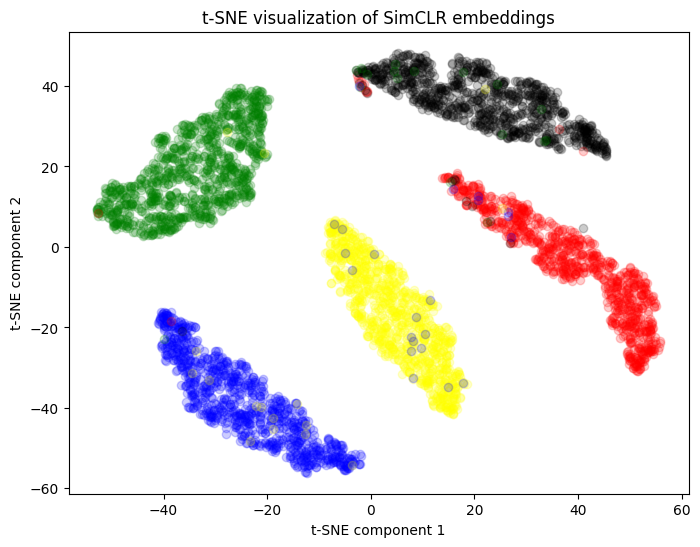

In [ ]:
sas_subset_tsne = get_tsne_embeddings(simclr_model_trained_on_sas, x_embed=simclr_sas_embeddings.detach(), get_embedding = False)
visualize_tsne_embeddings(sas_subset_tsne, train_label_dict, indices_for_group_partition = sas_subset.subset_indices,
                          title='t-SNE visualization of embeddings from SimCLR Trained on \n Subset Selected by SAS (Variance = {}, Correlation={})'.format(
                                                mp[D], C))

#### Train Linear Classifier

In [ ]:
simclr_model_trained_on_sas = torch.load("simclr_model_trained_on_sas.pkl", map_location=torch.device('cpu'))
simclr_sas_embeddings_val = get_simclr_embeddings(simclr_model_trained_on_sas, val_set)
linear_classifier_sas = train_linear_classifier(simclr_sas_embeddings_val.detach(), val_clabels, 7500)

In [ ]:
simclr_embeddings_test = get_simclr_embeddings(simclr_model_trained_on_sas, test_set)

get_group_wise_accuracy(simclr_embeddings_test,
                    linear_classifier_sas,
                    test_set,
                    curr_trainset)

torch.Size([5139, 16])


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:10,  2.31it/s]

Group (0, 0) Accuracy: 44.89795918367347


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:10,  2.24it/s]

Group (0, 1) Accuracy: 51.53061224489796


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:09,  2.29it/s]

Group (0, 2) Accuracy: 26.020408163265305


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:09,  2.24it/s]

Group (0, 3) Accuracy: 58.16326530612245


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:02<00:10,  1.93it/s]

Group (0, 4) Accuracy: 59.183673469387756


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:03<00:10,  1.78it/s]

Group (1, 0) Accuracy: 71.36563876651982


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:03<00:11,  1.64it/s]

Group (1, 1) Accuracy: 82.37885462555066


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:04<00:11,  1.49it/s]

Group (1, 2) Accuracy: 70.48458149779735


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:05<00:11,  1.43it/s]

Group (1, 3) Accuracy: 68.28193832599119


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:06<00:10,  1.39it/s]

Group (1, 4) Accuracy: 66.51982378854626


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:06<00:10,  1.36it/s]

Group (2, 0) Accuracy: 21.256038647342994


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:07<00:09,  1.37it/s]

Group (2, 1) Accuracy: 17.8743961352657


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:08<00:08,  1.37it/s]

Group (2, 2) Accuracy: 52.9126213592233


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:09<00:08,  1.31it/s]

Group (2, 3) Accuracy: 31.067961165048544


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:09<00:07,  1.30it/s]

Group (2, 4) Accuracy: 24.75728155339806


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:10<00:07,  1.29it/s]

Group (3, 0) Accuracy: 44.554455445544555


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:11<00:06,  1.33it/s]

Group (3, 1) Accuracy: 57.42574257425743


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:12<00:05,  1.36it/s]

Group (3, 2) Accuracy: 49.504950495049506


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:12<00:04,  1.41it/s]

Group (3, 3) Accuracy: 63.86138613861386


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:13<00:03,  1.46it/s]

Group (3, 4) Accuracy: 37.12871287128713


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:13<00:02,  1.65it/s]

Group (4, 0) Accuracy: 59.390862944162436


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:14<00:01,  1.79it/s]

Group (4, 1) Accuracy: 28.934010152284262


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:14<00:01,  1.92it/s]

Group (4, 2) Accuracy: 44.89795918367347


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:15<00:00,  2.00it/s]

Group (4, 3) Accuracy: 63.775510204081634


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]

Group (4, 4) Accuracy: 70.40816326530613
 
average accuracy:  61.89163479515074
worst-group accuracy:  ((2, 1), 17.8743961352657)


{(0, 0): 44.89795918367347,
 (0, 1): 51.53061224489796,
 (0, 2): 26.020408163265305,
 (0, 3): 58.16326530612245,
 (0, 4): 59.183673469387756,
 (1, 0): 71.36563876651982,
 (1, 1): 82.37885462555066,
 (1, 2): 70.48458149779735,
 (1, 3): 68.28193832599119,
 (1, 4): 66.51982378854626,
 (2, 0): 21.256038647342994,
 (2, 1): 17.8743961352657,
 (2, 2): 52.9126213592233,
 (2, 3): 31.067961165048544,
 (2, 4): 24.75728155339806,
 (3, 0): 44.554455445544555,
 (3, 1): 57.42574257425743,
 (3, 2): 49.504950495049506,
 (3, 3): 63.86138613861386,
 (3, 4): 37.12871287128713,
 (4, 0): 59.390862944162436,
 (4, 1): 28.934010152284262,
 (4, 2): 44.89795918367347,
 (4, 3): 63.775510204081634,
 (4, 4): 70.40816326530613}

In [36]:
simclr_model_trained_on_sas = torch.load("simclr_model_trained_on_sas.pkl", map_location=torch.device('cpu'))
simclr_sas_embeddings_val = get_simclr_embeddings(simclr_model_trained_on_sas, val_set)
linear_classifier_sas = train_linear_classifier(simclr_sas_embeddings_val.detach(), val_slabels, 7500)

simclr_embeddings_test = get_simclr_embeddings(simclr_model_trained_on_sas, test_set)

get_group_wise_accuracy(simclr_embeddings_test,
                    linear_classifier_sas,
                    test_set,
                    curr_trainset,
                        evaluate_on_color=True)

torch.Size([6117, 16])
Epoch 100/100, Loss: 0.9522294402122498
Epoch 200/100, Loss: 0.5839929580688477
Epoch 300/100, Loss: 0.430495023727417
Epoch 400/100, Loss: 0.3383060693740845
Epoch 500/100, Loss: 0.27620142698287964
Epoch 600/100, Loss: 0.23196075856685638
Epoch 700/100, Loss: 0.1993246227502823
Epoch 800/100, Loss: 0.17452667653560638
Epoch 900/100, Loss: 0.15516240894794464
Epoch 1000/100, Loss: 0.13966304063796997
Epoch 1100/100, Loss: 0.12698626518249512
Epoch 1200/100, Loss: 0.11642404645681381
Epoch 1300/100, Loss: 0.1074831560254097
Epoch 1400/100, Loss: 0.09981131553649902
Epoch 1500/100, Loss: 0.093150794506073
Epoch 1600/100, Loss: 0.08730904757976532
Epoch 1700/100, Loss: 0.08213932812213898
Epoch 1800/100, Loss: 0.0775279551744461
Epoch 1900/100, Loss: 0.07338551431894302
Epoch 2000/100, Loss: 0.06964071840047836
Epoch 2100/100, Loss: 0.06623615324497223
Epoch 2200/100, Loss: 0.06312496215105057
Epoch 2300/100, Loss: 0.06026864051818848
Epoch 2400/100, Loss: 0.057635

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([5139, 16])


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Group (0, 0) Accuracy: 99.48979591836735


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:02<00:24,  1.05s/it]

Group (0, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:03<00:25,  1.16s/it]

Group (0, 2) Accuracy: 97.44897959183673


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:04<00:22,  1.06s/it]

Group (0, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:05<00:19,  1.01it/s]

Group (0, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:06<00:18,  1.05it/s]

Group (1, 0) Accuracy: 100.0


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:07<00:18,  1.04s/it]

Group (1, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:08<00:19,  1.14s/it]

Group (1, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:10<00:19,  1.23s/it]

Group (1, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:11<00:19,  1.27s/it]

Group (1, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:12<00:17,  1.25s/it]

Group (2, 0) Accuracy: 100.0


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:13<00:14,  1.13s/it]

Group (2, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:14<00:12,  1.05s/it]

Group (2, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:15<00:10,  1.00it/s]

Group (2, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:16<00:09,  1.04it/s]

Group (2, 4) Accuracy: 99.51456310679612


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:16<00:08,  1.07it/s]

Group (3, 0) Accuracy: 99.00990099009901


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:17<00:07,  1.08it/s]

Group (3, 1) Accuracy: 99.00990099009901


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:18<00:06,  1.11it/s]

Group (3, 2) Accuracy: 99.5049504950495


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:19<00:05,  1.12it/s]

Group (3, 3) Accuracy: 99.5049504950495


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:20<00:04,  1.13it/s]

Group (3, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:21<00:03,  1.13it/s]

Group (4, 0) Accuracy: 98.98477157360406


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:22<00:02,  1.14it/s]

Group (4, 1) Accuracy: 98.98477157360406


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:23<00:01,  1.00it/s]

Group (4, 2) Accuracy: 98.9795918367347


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:24<00:01,  1.12s/it]

Group (4, 3) Accuracy: 97.44897959183673


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]

Group (4, 4) Accuracy: 100.0
 
average accuracy:  99.76941337749776
worst-group accuracy:  ((0, 2), 97.44897959183673)


{(0, 0): 99.48979591836735,
 (0, 1): 100.0,
 (0, 2): 97.44897959183673,
 (0, 3): 100.0,
 (0, 4): 100.0,
 (1, 0): 100.0,
 (1, 1): 100.0,
 (1, 2): 100.0,
 (1, 3): 100.0,
 (1, 4): 100.0,
 (2, 0): 100.0,
 (2, 1): 100.0,
 (2, 2): 100.0,
 (2, 3): 100.0,
 (2, 4): 99.51456310679612,
 (3, 0): 99.00990099009901,
 (3, 1): 99.00990099009901,
 (3, 2): 99.5049504950495,
 (3, 3): 99.5049504950495,
 (3, 4): 100.0,
 (4, 0): 98.98477157360406,
 (4, 1): 98.98477157360406,
 (4, 2): 98.9795918367347,
 (4, 3): 97.44897959183673,
 (4, 4): 100.0}

#### Upsample SAS Subset

In [20]:
data_set_for_sas = get_dataset_for_sas(train_set1, train_set2)
partition = get_partition(data_set_for_sas, proxy_model)
sas_subset = get_sas_subset(curr_trainset,
                            proxy_model,
                            partition,
                            subset_fraction=0.2,
                            num_downstream_classes=5)

Encoding data using proxy model provided: 100%|██████████| 1/1 [00:59<00:00, 59.08s/it]


used 5 iterations (0.0502s) to cluster 24064 items into 5 clusters


Subset Selection:: 100%|██████████| 5/5 [00:13<00:00,  2.60s/it]

Latent class: 4 Class size: 4643
Latent class: 3 Class size: 4648
Latent class: 0 Class size: 5274
Latent class: 1 Class size: 4700
Latent class: 2 Class size: 4799
Subset Size: 4895
Discarded 19584 examples


In [21]:
sas_subgroup_size = get_size_of_groups_selected_by_sas(sas_subset, train_label_dict)

In [ ]:
sorted(sas_subgroup_size, key=sas_subgroup_size.keys())

TypeError: ignored

In [22]:
threshold = len(sas_subset.subset_indices)//50
groups_to_upsample = []
for key, val in sas_subgroup_size.items():
    if val < threshold:
        groups_to_upsample.append(key)


In [ ]:
sorted(groups_to_upsample)

[(0, 1),
 (0, 2),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 4),
 (2, 0),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (4, 0),
 (4, 2)]

In [23]:
sas_subset_group_partition = get_group_partition_for_selected_subset(sas_subset.subset_indices, train_label_dict)

In [ ]:
len(sas_subset.subset_indices)

4810

In [24]:
indices_to_upsample = []
for group in groups_to_upsample:
    indices_to_upsample.extend(sas_subset_group_partition[group])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


len for subset before upsampling:  4810
len for subset after upsampling:  11910
num_extra_vals_to_add:  134
Epoch 1/100, Loss: 6.8737
Epoch 2/100, Loss: 6.3598
Epoch 3/100, Loss: 5.8481
Epoch 4/100, Loss: 5.3411
Epoch 5/100, Loss: 5.0576
Epoch 6/100, Loss: 4.8484
Epoch 7/100, Loss: 4.6972
Epoch 8/100, Loss: 4.6454
Epoch 9/100, Loss: 4.4914
Epoch 10/100, Loss: 4.4237
Epoch 11/100, Loss: 4.3316
Epoch 12/100, Loss: 4.2557
Epoch 13/100, Loss: 4.1776
Epoch 14/100, Loss: 4.1212
Epoch 15/100, Loss: 4.0977
Epoch 16/100, Loss: 4.0446
Epoch 17/100, Loss: 4.0092
Epoch 18/100, Loss: 3.9204
Epoch 19/100, Loss: 3.9176
Epoch 20/100, Loss: 3.8770
Epoch 21/100, Loss: 3.8350
Epoch 22/100, Loss: 3.8205
Epoch 23/100, Loss: 3.7885
Epoch 24/100, Loss: 3.7322
Epoch 25/100, Loss: 3.7201
Epoch 26/100, Loss: 3.6575
Epoch 27/100, Loss: 3.6637
Epoch 28/100, Loss: 3.6148
Epoch 29/100, Loss: 3.5985
Epoch 30/100, Loss: 3.6023
Epoch 31/100, Loss: 3.5899
Epoch 32/100, Loss: 3.5471
Epoch 33/100, Loss: 3.4894
Epoch 34/1

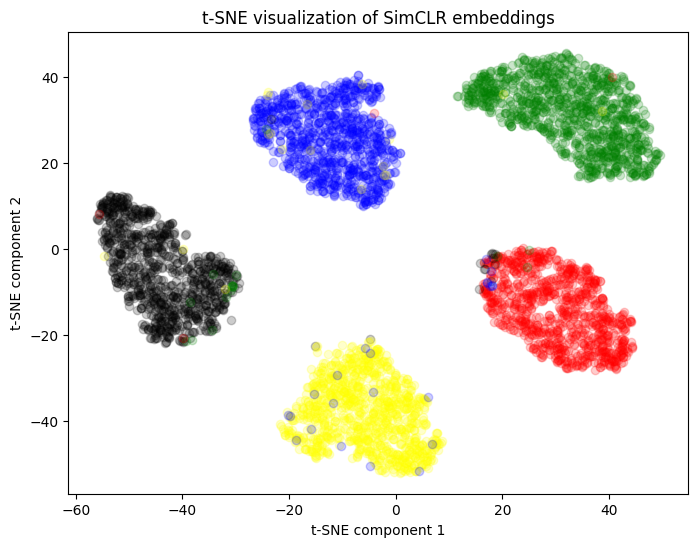

torch.Size([6117, 16])


TypeError: ignored

In [ ]:
upsample_factor = 100
simclr_model_trained_on_sas_upsampled, simclr_sas_embeddings_upsampled = train_simclr_model_on_sas_subset(sas_subset,
                                                                                      indices_to_upsample=indices_to_upsample,
                                                                                      upsample_factor = upsample_factor,
                                                                                      batch_size=512,
                                                                                      num_epochs=100)
torch.save(simclr_model_trained_on_sas_upsampled, "simclr_model_trained_on_sas_upsampled_{}.pkl".format(100))


# get T-SNE embeddings
subset_x_for_simclr = [elem[0].to(cpu_device) for elem in sas_subset]
simclr_sas_embeddings_train_upsampled_model = get_simclr_embeddings(simclr_model_trained_on_sas_upsampled, subset_x_for_simclr)
sas_subset_tsne = get_tsne_embeddings(simclr_model_trained_on_sas_upsampled, x_embed=simclr_sas_embeddings_train_upsampled_model.detach(), get_embedding = False)
visualize_tsne_embeddings(sas_subset_tsne, train_label_dict, indices_for_group_partition = sas_subset.subset_indices,
                          title='t-SNE visualization of embeddings from SimCLR Trained on \n Upsampled Subset Selected by SAS (Upsample Factor = {} Variance = {}, Correlation={})'.format(
                                                100, mp[D], C))




In [ ]:
torch.cuda.empty_cache()

In [ ]:
simclr_model_trained_on_sas_upsampled = torch.load("simclr_model_trained_on_sas_upsampled_{}.pkl".format(100))

# Train Linear Classifier on Val Set and get Group-Wise Accuracy
simclr_sas_embeddings_val = get_simclr_embeddings(simclr_model_trained_on_sas_upsampled, val_set)
linear_classifier_sas = train_linear_classifier(simclr_sas_embeddings_val.detach(), val_clabels, 7500)

simclr_embeddings_test = get_simclr_embeddings(simclr_model_trained_on_sas_upsampled, test_set)
get_group_wise_accuracy(simclr_embeddings_test,
                    linear_classifier_sas,
                    test_set,
                    curr_trainset)

torch.Size([6117, 16])
Epoch 100/100, Loss: 1.5556490421295166
Epoch 200/100, Loss: 1.257206678390503
Epoch 300/100, Loss: 1.1476415395736694
Epoch 400/100, Loss: 1.0910820960998535
Epoch 500/100, Loss: 1.0571401119232178
Epoch 600/100, Loss: 1.0343812704086304
Epoch 700/100, Loss: 1.0179041624069214
Epoch 800/100, Loss: 1.0053420066833496
Epoch 900/100, Loss: 0.9954157471656799
Epoch 1000/100, Loss: 0.9873608946800232
Epoch 1100/100, Loss: 0.9806818962097168
Epoch 1200/100, Loss: 0.9750354886054993
Epoch 1300/100, Loss: 0.970176100730896
Epoch 1400/100, Loss: 0.9659223556518555
Epoch 1500/100, Loss: 0.9621399641036987
Epoch 1600/100, Loss: 0.9587278366088867
Epoch 1700/100, Loss: 0.9556106328964233
Epoch 1800/100, Loss: 0.9527313113212585
Epoch 1900/100, Loss: 0.9500468373298645
Epoch 2000/100, Loss: 0.9475247859954834
Epoch 2100/100, Loss: 0.9451408982276917
Epoch 2200/100, Loss: 0.9428762197494507
Epoch 2300/100, Loss: 0.9407163262367249
Epoch 2400/100, Loss: 0.9386507272720337
Epoc

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([5139, 16])


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:10,  2.38it/s]

Group (0, 0) Accuracy: 71.93877551020408


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:08,  2.62it/s]

Group (0, 1) Accuracy: 48.46938775510204


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:08,  2.64it/s]

Group (0, 2) Accuracy: 42.3469387755102


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:07,  2.71it/s]

Group (0, 3) Accuracy: 37.244897959183675


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:07,  2.73it/s]

Group (0, 4) Accuracy: 62.244897959183675


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:02<00:06,  2.73it/s]

Group (1, 0) Accuracy: 69.60352422907489


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:02<00:06,  2.75it/s]

Group (1, 1) Accuracy: 81.05726872246696


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:02<00:06,  2.78it/s]

Group (1, 2) Accuracy: 53.30396475770925


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:03<00:05,  2.75it/s]

Group (1, 3) Accuracy: 87.66519823788546


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:03<00:05,  2.76it/s]

Group (1, 4) Accuracy: 77.97356828193833


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:04<00:05,  2.76it/s]

Group (2, 0) Accuracy: 61.83574879227053


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:04<00:04,  2.75it/s]

Group (2, 1) Accuracy: 49.75845410628019


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:04<00:04,  2.76it/s]

Group (2, 2) Accuracy: 42.71844660194175


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:05<00:03,  2.76it/s]

Group (2, 3) Accuracy: 37.37864077669903


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:05<00:03,  2.76it/s]

Group (2, 4) Accuracy: 58.737864077669904


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:05<00:03,  2.79it/s]

Group (3, 0) Accuracy: 74.75247524752476


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:06<00:02,  2.78it/s]

Group (3, 1) Accuracy: 76.23762376237623


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:06<00:02,  2.77it/s]

Group (3, 2) Accuracy: 75.74257425742574


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:06<00:02,  2.76it/s]

Group (3, 3) Accuracy: 80.6930693069307


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:07<00:01,  2.76it/s]

Group (3, 4) Accuracy: 60.89108910891089


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:07<00:01,  2.73it/s]

Group (4, 0) Accuracy: 71.06598984771574


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:08<00:01,  2.72it/s]

Group (4, 1) Accuracy: 77.66497461928934


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:08<00:00,  2.64it/s]

Group (4, 2) Accuracy: 76.53061224489795


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:08<00:00,  2.64it/s]

Group (4, 3) Accuracy: 66.3265306122449


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]

Group (4, 4) Accuracy: 66.83673469387755
 
average accuracy:  68.47885694496324
worst-group accuracy:  ((0, 3), 37.244897959183675)


{(0, 0): 71.93877551020408,
 (0, 1): 48.46938775510204,
 (0, 2): 42.3469387755102,
 (0, 3): 37.244897959183675,
 (0, 4): 62.244897959183675,
 (1, 0): 69.60352422907489,
 (1, 1): 81.05726872246696,
 (1, 2): 53.30396475770925,
 (1, 3): 87.66519823788546,
 (1, 4): 77.97356828193833,
 (2, 0): 61.83574879227053,
 (2, 1): 49.75845410628019,
 (2, 2): 42.71844660194175,
 (2, 3): 37.37864077669903,
 (2, 4): 58.737864077669904,
 (3, 0): 74.75247524752476,
 (3, 1): 76.23762376237623,
 (3, 2): 75.74257425742574,
 (3, 3): 80.6930693069307,
 (3, 4): 60.89108910891089,
 (4, 0): 71.06598984771574,
 (4, 1): 77.66497461928934,
 (4, 2): 76.53061224489795,
 (4, 3): 66.3265306122449,
 (4, 4): 66.83673469387755}

In [25]:
simclr_model_trained_on_sas_upsampled = torch.load("simclr_model_trained_on_sas_upsampled_{}.pkl".format(100))

# Train Linear Classifier on Val Set and get Group-Wise Accuracy
simclr_sas_embeddings_val = get_simclr_embeddings(simclr_model_trained_on_sas_upsampled, val_set)
linear_classifier_sas = train_linear_classifier(simclr_sas_embeddings_val.detach(), val_slabels, 7500)

simclr_embeddings_test = get_simclr_embeddings(simclr_model_trained_on_sas_upsampled, test_set)

get_group_wise_accuracy(simclr_embeddings_test,
                    linear_classifier_sas,
                    test_set,
                    curr_trainset,
                        evaluate_on_color=True)

torch.Size([6117, 16])
Epoch 100/100, Loss: 0.8641536235809326
Epoch 200/100, Loss: 0.3367748558521271
Epoch 300/100, Loss: 0.22773155570030212
Epoch 400/100, Loss: 0.17673926055431366
Epoch 500/100, Loss: 0.14642202854156494
Epoch 600/100, Loss: 0.12612789869308472
Epoch 700/100, Loss: 0.1115204468369484
Epoch 800/100, Loss: 0.10046589374542236
Epoch 900/100, Loss: 0.09178270399570465
Epoch 1000/100, Loss: 0.08476191014051437
Epoch 1100/100, Loss: 0.07895240187644958
Epoch 1200/100, Loss: 0.074053555727005
Epoch 1300/100, Loss: 0.06985749304294586
Epoch 1400/100, Loss: 0.0662158727645874
Epoch 1500/100, Loss: 0.06301997601985931
Epoch 1600/100, Loss: 0.06018832325935364
Epoch 1700/100, Loss: 0.05765845626592636
Epoch 1800/100, Loss: 0.05538180470466614
Epoch 1900/100, Loss: 0.05331992730498314
Epoch 2000/100, Loss: 0.05144191160798073
Epoch 2100/100, Loss: 0.04972272738814354
Epoch 2200/100, Loss: 0.048141784965991974
Epoch 2300/100, Loss: 0.04668199270963669
Epoch 2400/100, Loss: 0.0

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([5139, 16])


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:06,  3.79it/s]

Group (0, 0) Accuracy: 100.0


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:06,  3.68it/s]

Group (0, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:00<00:06,  3.45it/s]

Group (0, 2) Accuracy: 98.9795918367347


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:07,  2.96it/s]

Group (0, 3) Accuracy: 97.44897959183673


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:07,  2.69it/s]

Group (0, 4) Accuracy: 99.48979591836735


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:02<00:07,  2.52it/s]

Group (1, 0) Accuracy: 100.0


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:02<00:07,  2.49it/s]

Group (1, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:02<00:06,  2.45it/s]

Group (1, 2) Accuracy: 99.55947136563877


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:03<00:06,  2.47it/s]

Group (1, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:03<00:06,  2.48it/s]

Group (1, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:04<00:05,  2.49it/s]

Group (2, 0) Accuracy: 100.0


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:04<00:05,  2.48it/s]

Group (2, 1) Accuracy: 98.55072463768116


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:05<00:04,  2.44it/s]

Group (2, 2) Accuracy: 99.51456310679612


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:05<00:04,  2.49it/s]

Group (2, 3) Accuracy: 96.60194174757281


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:05<00:03,  2.51it/s]

Group (2, 4) Accuracy: 98.54368932038835


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:06<00:03,  2.79it/s]

Group (3, 0) Accuracy: 98.01980198019803


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:06<00:02,  3.05it/s]

Group (3, 1) Accuracy: 96.53465346534654


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:06<00:02,  3.22it/s]

Group (3, 2) Accuracy: 99.00990099009901


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:06<00:01,  3.31it/s]

Group (3, 3) Accuracy: 99.00990099009901


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:07<00:01,  3.48it/s]

Group (3, 4) Accuracy: 96.03960396039604


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:07<00:01,  3.58it/s]

Group (4, 0) Accuracy: 97.96954314720813


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:07<00:00,  3.66it/s]

Group (4, 1) Accuracy: 97.96954314720813


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:07<00:00,  3.65it/s]

Group (4, 2) Accuracy: 98.46938775510205


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:08<00:00,  3.72it/s]

Group (4, 3) Accuracy: 99.48979591836735


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s]

Group (4, 4) Accuracy: 98.9795918367347
 
average accuracy:  99.42668133124421
worst-group accuracy:  ((3, 4), 96.03960396039604)


{(0, 0): 100.0,
 (0, 1): 100.0,
 (0, 2): 98.9795918367347,
 (0, 3): 97.44897959183673,
 (0, 4): 99.48979591836735,
 (1, 0): 100.0,
 (1, 1): 100.0,
 (1, 2): 99.55947136563877,
 (1, 3): 100.0,
 (1, 4): 100.0,
 (2, 0): 100.0,
 (2, 1): 98.55072463768116,
 (2, 2): 99.51456310679612,
 (2, 3): 96.60194174757281,
 (2, 4): 98.54368932038835,
 (3, 0): 98.01980198019803,
 (3, 1): 96.53465346534654,
 (3, 2): 99.00990099009901,
 (3, 3): 99.00990099009901,
 (3, 4): 96.03960396039604,
 (4, 0): 97.96954314720813,
 (4, 1): 97.96954314720813,
 (4, 2): 98.46938775510205,
 (4, 3): 99.48979591836735,
 (4, 4): 98.9795918367347}

In [ ]:
get_group_wise_accuracy(simclr_embeddings_test,
                    linear_classifier_sas,
                    test_set,
                    curr_trainset)

In [ ]:
get_group_wise_accuracy(simclr_embeddings_test,
                    linear_classifier_sas,
                    test_set,
                    curr_trainset)

In [ ]:
upsample_factor = 50
simclr_model_trained_on_sas_upsampled_50, simclr_sas_embeddings_upsampled_50 = train_simclr_model_on_sas_subset(sas_subset,
                                                                                      indices_to_upsample=indices_to_upsample,
                                                                                      upsample_factor = upsample_factor,
                                                                                      batch_size=512,
                                                                                      num_epochs=100)
torch.save(simclr_model_trained_on_sas_upsampled_50, "simclr_model_trained_on_sas_upsampled_{}.pkl".format(upsample_factor))




len for subset beefore upsampling:  4810
len for subset after upsampling:  8360
num_extra_vals_to_add:  168


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/100, Loss: 6.8798
Epoch 2/100, Loss: 6.4219
Epoch 3/100, Loss: 6.1098
Epoch 4/100, Loss: 5.6800
Epoch 5/100, Loss: 5.3999
Epoch 6/100, Loss: 5.1757
Epoch 7/100, Loss: 5.0358
Epoch 8/100, Loss: 4.9229
Epoch 9/100, Loss: 4.8632
Epoch 10/100, Loss: 4.7686
Epoch 11/100, Loss: 4.7350
Epoch 12/100, Loss: 4.6701
Epoch 13/100, Loss: 4.6058
Epoch 14/100, Loss: 4.5698
Epoch 15/100, Loss: 4.5116
Epoch 16/100, Loss: 4.4196
Epoch 17/100, Loss: 4.3799
Epoch 18/100, Loss: 4.3077
Epoch 19/100, Loss: 4.2930
Epoch 20/100, Loss: 4.2846
Epoch 21/100, Loss: 4.2563
Epoch 22/100, Loss: 4.2029
Epoch 23/100, Loss: 4.1304
Epoch 24/100, Loss: 4.1217
Epoch 25/100, Loss: 4.0887
Epoch 26/100, Loss: 4.0627
Epoch 27/100, Loss: 4.0204
Epoch 28/100, Loss: 3.9661
Epoch 29/100, Loss: 3.9473
Epoch 30/100, Loss: 3.9357
Epoch 31/100, Loss: 3.8384
Epoch 32/100, Loss: 3.9020
Epoch 33/100, Loss: 3.8534
Epoch 34/100, Loss: 3.8412
Epoch 35/100, Loss: 3.8422
Epoch 36/100, Loss: 3.7697
Epoch 37/100, Loss: 3.7643
Epoch 38/1

NameError: ignored

In [26]:
simclr_model_trained_on_sas_upsampled = torch.load("simclr_model_trained_on_sas_upsampled_{}.pkl".format(50))

# Train Linear Classifier on Val Set and get Group-Wise Accuracy
simclr_sas_embeddings_val = get_simclr_embeddings(simclr_model_trained_on_sas_upsampled, val_set)
linear_classifier_sas = train_linear_classifier(simclr_sas_embeddings_val.detach(), val_slabels, 7500)

simclr_embeddings_test = get_simclr_embeddings(simclr_model_trained_on_sas_upsampled, test_set)

get_group_wise_accuracy(simclr_embeddings_test,
                    linear_classifier_sas,
                    test_set,
                    curr_trainset,
                        evaluate_on_color=True)

torch.Size([6117, 16])
Epoch 100/100, Loss: 0.5765256285667419
Epoch 200/100, Loss: 0.16018053889274597
Epoch 300/100, Loss: 0.08253733068704605
Epoch 400/100, Loss: 0.05561388283967972
Epoch 500/100, Loss: 0.042139071971178055
Epoch 600/100, Loss: 0.03398548811674118
Epoch 700/100, Loss: 0.028486577793955803
Epoch 800/100, Loss: 0.024511929601430893
Epoch 900/100, Loss: 0.02149774879217148
Epoch 1000/100, Loss: 0.01912952959537506
Epoch 1100/100, Loss: 0.017217185348272324
Epoch 1200/100, Loss: 0.01563883014023304
Epoch 1300/100, Loss: 0.014312648214399815
Epoch 1400/100, Loss: 0.013181665912270546
Epoch 1500/100, Loss: 0.012204979546368122
Epoch 1600/100, Loss: 0.01135246828198433
Epoch 1700/100, Loss: 0.010601434856653214
Epoch 1800/100, Loss: 0.009934444911777973
Epoch 1900/100, Loss: 0.009337886236608028
Epoch 2000/100, Loss: 0.008800957351922989
Epoch 2100/100, Loss: 0.008314980193972588
Epoch 2200/100, Loss: 0.00787289533764124
Epoch 2300/100, Loss: 0.007468890398740768
Epoch 24

Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:06,  3.55it/s]

Group (0, 0) Accuracy: 100.0


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:06,  3.52it/s]

Group (0, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:00<00:06,  3.60it/s]

Group (0, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:05,  3.62it/s]

Group (0, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:05,  3.66it/s]

Group (0, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:01<00:05,  3.65it/s]

Group (1, 0) Accuracy: 100.0


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:01<00:04,  3.66it/s]

Group (1, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:02<00:04,  3.67it/s]

Group (1, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:02<00:04,  3.68it/s]

Group (1, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:02<00:04,  3.63it/s]

Group (1, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:03<00:03,  3.57it/s]

Group (2, 0) Accuracy: 100.0


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:03<00:03,  3.51it/s]

Group (2, 1) Accuracy: 99.51690821256038


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:03<00:03,  3.46it/s]

Group (2, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:03<00:03,  3.49it/s]

Group (2, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:04<00:02,  3.49it/s]

Group (2, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:04<00:02,  3.45it/s]

Group (3, 0) Accuracy: 99.5049504950495


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:04<00:02,  3.03it/s]

Group (3, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:05<00:02,  2.76it/s]

Group (3, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:05<00:02,  2.53it/s]

Group (3, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:06<00:02,  2.43it/s]

Group (3, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:06<00:01,  2.32it/s]

Group (4, 0) Accuracy: 100.0


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:07<00:01,  2.31it/s]

Group (4, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:07<00:00,  2.32it/s]

Group (4, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:08<00:00,  2.23it/s]

Group (4, 3) Accuracy: 100.0


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:08<00:00,  2.89it/s]

Group (4, 4) Accuracy: 100.0
 
average accuracy:  99.99522424032776
worst-group accuracy:  ((3, 0), 99.5049504950495)


{(0, 0): 100.0,
 (0, 1): 100.0,
 (0, 2): 100.0,
 (0, 3): 100.0,
 (0, 4): 100.0,
 (1, 0): 100.0,
 (1, 1): 100.0,
 (1, 2): 100.0,
 (1, 3): 100.0,
 (1, 4): 100.0,
 (2, 0): 100.0,
 (2, 1): 99.51690821256038,
 (2, 2): 100.0,
 (2, 3): 100.0,
 (2, 4): 100.0,
 (3, 0): 99.5049504950495,
 (3, 1): 100.0,
 (3, 2): 100.0,
 (3, 3): 100.0,
 (3, 4): 100.0,
 (4, 0): 100.0,
 (4, 1): 100.0,
 (4, 2): 100.0,
 (4, 3): 100.0,
 (4, 4): 100.0}

torch.Size([4810, 16])
torch.Size([4810, 16])


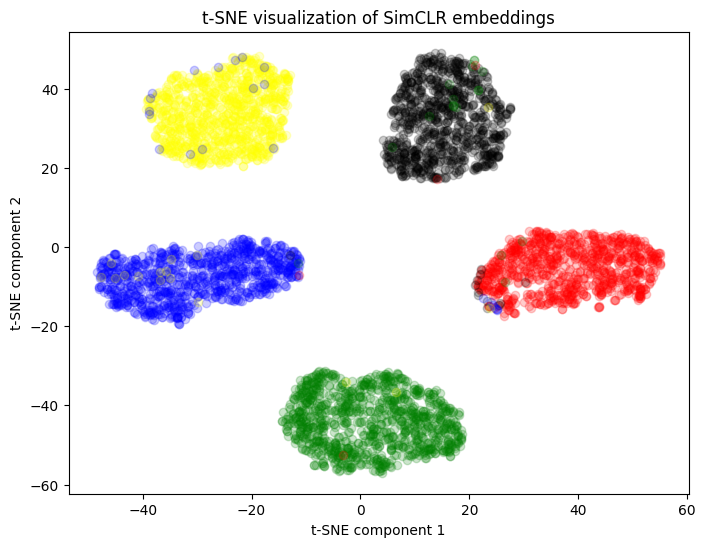

torch.Size([6117, 16])
Epoch 100/100, Loss: 1.8566207885742188
Epoch 200/100, Loss: 1.3474520444869995
Epoch 300/100, Loss: 1.2306722402572632
Epoch 400/100, Loss: 1.1762769222259521
Epoch 500/100, Loss: 1.1415235996246338
Epoch 600/100, Loss: 1.1169607639312744
Epoch 700/100, Loss: 1.0986981391906738
Epoch 800/100, Loss: 1.0846737623214722
Epoch 900/100, Loss: 1.0736281871795654
Epoch 1000/100, Loss: 1.0647274255752563
Epoch 1100/100, Loss: 1.0573972463607788
Epoch 1200/100, Loss: 1.0512343645095825
Epoch 1300/100, Loss: 1.0459531545639038
Epoch 1400/100, Loss: 1.0413482189178467
Epoch 1500/100, Loss: 1.0372731685638428
Epoch 1600/100, Loss: 1.0336215496063232
Epoch 1700/100, Loss: 1.0303165912628174
Epoch 1800/100, Loss: 1.0273020267486572
Epoch 1900/100, Loss: 1.0245349407196045
Epoch 2000/100, Loss: 1.021984338760376
Epoch 2100/100, Loss: 1.0196253061294556
Epoch 2200/100, Loss: 1.0174373388290405
Epoch 2300/100, Loss: 1.0154043436050415
Epoch 2400/100, Loss: 1.0135117769241333
Epo

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([5139, 16])


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:10,  2.37it/s]

Group (0, 0) Accuracy: 44.38775510204081


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:09,  2.49it/s]

Group (0, 1) Accuracy: 73.46938775510205


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:08,  2.50it/s]

Group (0, 2) Accuracy: 57.142857142857146


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:10,  1.96it/s]

Group (0, 3) Accuracy: 38.265306122448976


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:02<00:12,  1.60it/s]

Group (0, 4) Accuracy: 56.63265306122449


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:03<00:11,  1.60it/s]

Group (1, 0) Accuracy: 84.14096916299559


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:03<00:11,  1.61it/s]

Group (1, 1) Accuracy: 82.81938325991189


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:04<00:10,  1.65it/s]

Group (1, 2) Accuracy: 80.1762114537445


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:05<00:09,  1.65it/s]

Group (1, 3) Accuracy: 49.779735682819386


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:05<00:08,  1.67it/s]

Group (1, 4) Accuracy: 86.78414096916299


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:06<00:08,  1.63it/s]

Group (2, 0) Accuracy: 62.80193236714976


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:06<00:07,  1.65it/s]

Group (2, 1) Accuracy: 55.072463768115945


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:07<00:07,  1.63it/s]

Group (2, 2) Accuracy: 69.41747572815534


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:08<00:06,  1.61it/s]

Group (2, 3) Accuracy: 40.29126213592233


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:08<00:06,  1.64it/s]

Group (2, 4) Accuracy: 43.20388349514563


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:09<00:05,  1.75it/s]

Group (3, 0) Accuracy: 54.45544554455446


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:09<00:04,  1.92it/s]

Group (3, 1) Accuracy: 54.45544554455446


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:10<00:03,  2.06it/s]

Group (3, 2) Accuracy: 64.85148514851485


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:10<00:02,  2.19it/s]

Group (3, 3) Accuracy: 73.26732673267327


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:10<00:02,  2.24it/s]

Group (3, 4) Accuracy: 63.366336633663366


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:11<00:02,  1.66it/s]

Group (4, 0) Accuracy: 74.11167512690355


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:12<00:01,  1.64it/s]

Group (4, 1) Accuracy: 71.06598984771574


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:13<00:01,  1.52it/s]

Group (4, 2) Accuracy: 52.55102040816327


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:13<00:00,  1.72it/s]

Group (4, 3) Accuracy: 55.10204081632653


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]

Group (4, 4) Accuracy: 63.775510204081634
 
average accuracy:  66.65770054281012
worst-group accuracy:  ((0, 3), 38.265306122448976)


{(0, 0): 44.38775510204081,
 (0, 1): 73.46938775510205,
 (0, 2): 57.142857142857146,
 (0, 3): 38.265306122448976,
 (0, 4): 56.63265306122449,
 (1, 0): 84.14096916299559,
 (1, 1): 82.81938325991189,
 (1, 2): 80.1762114537445,
 (1, 3): 49.779735682819386,
 (1, 4): 86.78414096916299,
 (2, 0): 62.80193236714976,
 (2, 1): 55.072463768115945,
 (2, 2): 69.41747572815534,
 (2, 3): 40.29126213592233,
 (2, 4): 43.20388349514563,
 (3, 0): 54.45544554455446,
 (3, 1): 54.45544554455446,
 (3, 2): 64.85148514851485,
 (3, 3): 73.26732673267327,
 (3, 4): 63.366336633663366,
 (4, 0): 74.11167512690355,
 (4, 1): 71.06598984771574,
 (4, 2): 52.55102040816327,
 (4, 3): 55.10204081632653,
 (4, 4): 63.775510204081634}

In [ ]:
#simclr_model_trained_on_sas_upsampled_50 = torch.load(
#                    "simclr_model_trained_on_sas_upsampled_{}.pkl".format(upsample_factor))

## Get T-SNE embedding
curr_model = simclr_model_trained_on_sas_upsampled_50
curr_embedding = simclr_sas_embeddings_upsampled_50

subset_x_for_simclr = [elem[0].to(cpu_device) for elem in sas_subset]
simclr_sas_embeddings_train_upsampled_model = get_simclr_embeddings(curr_model, subset_x_for_simclr)
sas_subset_tsne = get_tsne_embeddings(curr_model, x_embed=curr_embedding.detach(), get_embedding = False)
visualize_tsne_embeddings(sas_subset_tsne, train_label_dict, indices_for_group_partition = sas_subset.subset_indices,
                          title='t-SNE visualization of embeddings from SimCLR Trained on \n Upsampled Subset Selected by SAS (Upsample Factor = {} Variance = {}, Correlation={})'.format(
                                                50, mp[D], C))


# Train Linear Classifier on Val Set and get Group-Wise Accuracy

simclr_sas_embeddings_val = get_simclr_embeddings(curr_model, val_set)
linear_classifier_sas = train_linear_classifier(simclr_sas_embeddings_val.detach(), val_clabels, 7500)

simclr_embeddings_test = get_simclr_embeddings(curr_model, test_set)

get_group_wise_accuracy(simclr_embeddings_test,
                    linear_classifier_sas,
                    test_set,
                    curr_trainset)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


len for subset beefore upsampling:  4810
len for subset after upsampling:  6230
num_extra_vals_to_add:  86
Epoch 1/100, Loss: 7.0516
Epoch 2/100, Loss: 6.5720
Epoch 3/100, Loss: 6.3592
Epoch 4/100, Loss: 6.1062
Epoch 5/100, Loss: 5.8110
Epoch 6/100, Loss: 5.5768
Epoch 7/100, Loss: 5.4119
Epoch 8/100, Loss: 5.2877
Epoch 9/100, Loss: 5.1707
Epoch 10/100, Loss: 5.1134
Epoch 11/100, Loss: 5.0623
Epoch 12/100, Loss: 4.9977
Epoch 13/100, Loss: 4.9442
Epoch 14/100, Loss: 4.9076
Epoch 15/100, Loss: 4.8735
Epoch 16/100, Loss: 4.8232
Epoch 17/100, Loss: 4.7808
Epoch 18/100, Loss: 4.7776
Epoch 19/100, Loss: 4.7764
Epoch 20/100, Loss: 4.7238
Epoch 21/100, Loss: 4.6821
Epoch 22/100, Loss: 4.6720
Epoch 23/100, Loss: 4.6414
Epoch 24/100, Loss: 4.5920
Epoch 25/100, Loss: 4.5683
Epoch 26/100, Loss: 4.5264
Epoch 27/100, Loss: 4.5161
Epoch 28/100, Loss: 4.5114
Epoch 29/100, Loss: 4.4812
Epoch 30/100, Loss: 4.4278
Epoch 31/100, Loss: 4.4203
Epoch 32/100, Loss: 4.3943
Epoch 33/100, Loss: 4.3604
Epoch 34/10

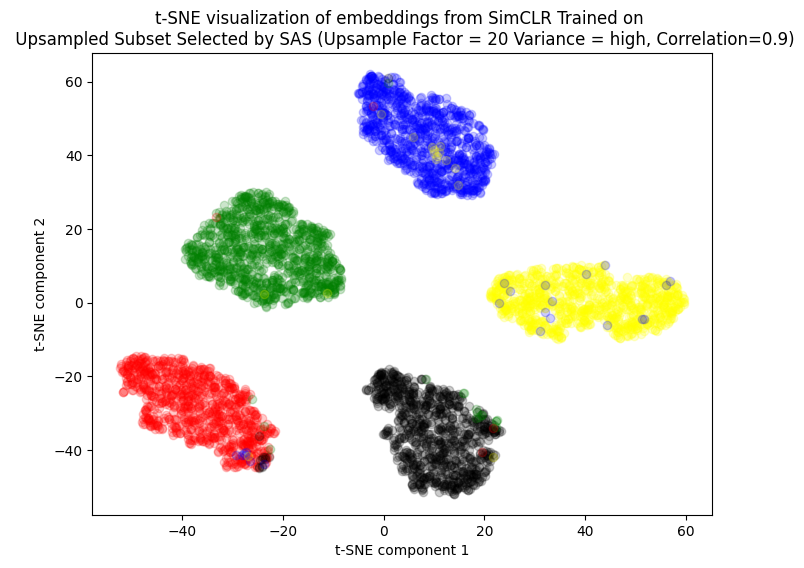

torch.Size([6117, 16])
Epoch 100/100, Loss: 2.1541290283203125
Epoch 200/100, Loss: 1.5714783668518066
Epoch 300/100, Loss: 1.3706871271133423
Epoch 400/100, Loss: 1.2690272331237793
Epoch 500/100, Loss: 1.2116245031356812
Epoch 600/100, Loss: 1.1742349863052368
Epoch 700/100, Loss: 1.1470484733581543
Epoch 800/100, Loss: 1.1259644031524658
Epoch 900/100, Loss: 1.108986496925354
Epoch 1000/100, Loss: 1.0949689149856567
Epoch 1100/100, Loss: 1.0831718444824219
Epoch 1200/100, Loss: 1.0730831623077393
Epoch 1300/100, Loss: 1.0643320083618164
Epoch 1400/100, Loss: 1.0566405057907104
Epoch 1500/100, Loss: 1.0497974157333374
Epoch 1600/100, Loss: 1.0436378717422485
Epoch 1700/100, Loss: 1.0380321741104126
Epoch 1800/100, Loss: 1.0328781604766846
Epoch 1900/100, Loss: 1.0280945301055908
Epoch 2000/100, Loss: 1.023616909980774
Epoch 2100/100, Loss: 1.0193939208984375
Epoch 2200/100, Loss: 1.0153855085372925
Epoch 2300/100, Loss: 1.0115606784820557
Epoch 2400/100, Loss: 1.00789475440979
Epoch 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([5139, 16])


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:08,  2.70it/s]

Group (0, 0) Accuracy: 65.81632653061224


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:08,  2.65it/s]

Group (0, 1) Accuracy: 69.89795918367346


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:08,  2.64it/s]

Group (0, 2) Accuracy: 37.755102040816325


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:07,  2.65it/s]

Group (0, 3) Accuracy: 43.36734693877551


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:07,  2.67it/s]

Group (0, 4) Accuracy: 58.16326530612245


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:02<00:07,  2.68it/s]

Group (1, 0) Accuracy: 90.7488986784141


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:02<00:06,  2.67it/s]

Group (1, 1) Accuracy: 89.42731277533039


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:02<00:06,  2.69it/s]

Group (1, 2) Accuracy: 95.15418502202643


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:03<00:05,  2.69it/s]

Group (1, 3) Accuracy: 85.90308370044053


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:03<00:05,  2.66it/s]

Group (1, 4) Accuracy: 92.51101321585904


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:04<00:05,  2.69it/s]

Group (2, 0) Accuracy: 65.70048309178743


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:04<00:04,  2.66it/s]

Group (2, 1) Accuracy: 62.80193236714976


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:04<00:04,  2.65it/s]

Group (2, 2) Accuracy: 66.99029126213593


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:05<00:04,  2.66it/s]

Group (2, 3) Accuracy: 45.63106796116505


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:05<00:03,  2.67it/s]

Group (2, 4) Accuracy: 33.49514563106796


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:05<00:03,  2.67it/s]

Group (3, 0) Accuracy: 43.56435643564357


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:06<00:03,  2.64it/s]

Group (3, 1) Accuracy: 53.46534653465346


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:06<00:02,  2.65it/s]

Group (3, 2) Accuracy: 56.43564356435643


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:07<00:02,  2.65it/s]

Group (3, 3) Accuracy: 50.99009900990099


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:07<00:01,  2.64it/s]

Group (3, 4) Accuracy: 64.35643564356435


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:07<00:01,  2.64it/s]

Group (4, 0) Accuracy: 67.00507614213198


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:08<00:01,  2.65it/s]

Group (4, 1) Accuracy: 58.88324873096447


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:08<00:00,  2.60it/s]

Group (4, 2) Accuracy: 54.59183673469388


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:09<00:00,  2.29it/s]

Group (4, 3) Accuracy: 67.34693877551021


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]

Group (4, 4) Accuracy: 70.91836734693878
 
average accuracy:  68.66579886919456
worst-group accuracy:  ((2, 4), 33.49514563106796)


{(0, 0): 65.81632653061224,
 (0, 1): 69.89795918367346,
 (0, 2): 37.755102040816325,
 (0, 3): 43.36734693877551,
 (0, 4): 58.16326530612245,
 (1, 0): 90.7488986784141,
 (1, 1): 89.42731277533039,
 (1, 2): 95.15418502202643,
 (1, 3): 85.90308370044053,
 (1, 4): 92.51101321585904,
 (2, 0): 65.70048309178743,
 (2, 1): 62.80193236714976,
 (2, 2): 66.99029126213593,
 (2, 3): 45.63106796116505,
 (2, 4): 33.49514563106796,
 (3, 0): 43.56435643564357,
 (3, 1): 53.46534653465346,
 (3, 2): 56.43564356435643,
 (3, 3): 50.99009900990099,
 (3, 4): 64.35643564356435,
 (4, 0): 67.00507614213198,
 (4, 1): 58.88324873096447,
 (4, 2): 54.59183673469388,
 (4, 3): 67.34693877551021,
 (4, 4): 70.91836734693878}

In [ ]:
upsample_factor = 20
simclr_model_trained_on_sas_upsampled_20, simclr_sas_embeddings_upsampled_20 = train_simclr_model_on_sas_subset(sas_subset,
                                                                                      indices_to_upsample=indices_to_upsample,
                                                                                      upsample_factor = upsample_factor,
                                                                                      batch_size=512,
                                                                                      num_epochs=100)
torch.save(simclr_model_trained_on_sas_upsampled_20, "simclr_model_trained_on_sas_upsampled_{}.pkl".format(upsample_factor))


## Get T-SNE embedding
curr_model = simclr_model_trained_on_sas_upsampled_20
curr_embedding = simclr_sas_embeddings_upsampled_20

subset_x_for_simclr = [elem[0].to(cpu_device) for elem in sas_subset]
simclr_sas_embeddings_train_upsampled_model = get_simclr_embeddings(curr_model, subset_x_for_simclr)
sas_subset_tsne = get_tsne_embeddings(curr_model, x_embed=curr_embedding.detach(), get_embedding = False)
visualize_tsne_embeddings(sas_subset_tsne, train_label_dict, indices_for_group_partition = sas_subset.subset_indices,
                          title='t-SNE visualization of embeddings from SimCLR Trained on \n Upsampled Subset Selected by SAS (Upsample Factor = {} Variance = {}, Correlation={})'.format(
                                                20, mp[D], C))


# Train Linear Classifier on Val Set and get Group-Wise Accuracy
curr_model = simclr_model_trained_on_sas_upsampled_20
curr_embedding = simclr_sas_embeddings_upsampled_20

simclr_sas_embeddings_val = get_simclr_embeddings(curr_model, val_set)
linear_classifier_sas = train_linear_classifier(simclr_sas_embeddings_val.detach(), val_clabels, 7500)

simclr_embeddings_test = get_simclr_embeddings(curr_model, test_set)

get_group_wise_accuracy(simclr_embeddings_test,
                    linear_classifier_sas,
                    test_set,
                    curr_trainset)


In [27]:
simclr_model_trained_on_sas_upsampled = torch.load("simclr_model_trained_on_sas_upsampled_{}.pkl".format(20))

# Train Linear Classifier on Val Set and get Group-Wise Accuracy
simclr_sas_embeddings_val = get_simclr_embeddings(simclr_model_trained_on_sas_upsampled, val_set)
linear_classifier_sas = train_linear_classifier(simclr_sas_embeddings_val.detach(), val_slabels, 7500)

simclr_embeddings_test = get_simclr_embeddings(simclr_model_trained_on_sas_upsampled, test_set)

get_group_wise_accuracy(simclr_embeddings_test,
                    linear_classifier_sas,
                    test_set,
                    curr_trainset,
                        evaluate_on_color=True)

torch.Size([6117, 16])
Epoch 100/100, Loss: 1.121921181678772
Epoch 200/100, Loss: 0.15140055119991302
Epoch 300/100, Loss: 0.06969554722309113
Epoch 400/100, Loss: 0.042508531361818314
Epoch 500/100, Loss: 0.02965809404850006
Epoch 600/100, Loss: 0.022381538525223732
Epoch 700/100, Loss: 0.017772028222680092
Epoch 800/100, Loss: 0.014620520174503326
Epoch 900/100, Loss: 0.012344100512564182
Epoch 1000/100, Loss: 0.010630431585013866
Epoch 1100/100, Loss: 0.009298330172896385
Epoch 1200/100, Loss: 0.008235970512032509
Epoch 1300/100, Loss: 0.007370817009359598
Epoch 1400/100, Loss: 0.006653889548033476
Epoch 1500/100, Loss: 0.006050981115549803
Epoch 1600/100, Loss: 0.0055375187657773495
Epoch 1700/100, Loss: 0.005095412023365498
Epoch 1800/100, Loss: 0.004711070563644171
Epoch 1900/100, Loss: 0.004374097101390362
Epoch 2000/100, Loss: 0.004076406825333834
Epoch 2100/100, Loss: 0.0038116213399916887
Epoch 2200/100, Loss: 0.003574651898816228
Epoch 2300/100, Loss: 0.0033613883424550295


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:06,  3.52it/s]

Group (0, 0) Accuracy: 100.0


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:06,  3.39it/s]

Group (0, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:00<00:06,  3.42it/s]

Group (0, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:06,  3.49it/s]

Group (0, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:05,  3.46it/s]

Group (0, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:01<00:05,  3.46it/s]

Group (1, 0) Accuracy: 100.0


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:02<00:05,  3.48it/s]

Group (1, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:02<00:04,  3.42it/s]

Group (1, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:02<00:04,  3.38it/s]

Group (1, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:02<00:04,  3.44it/s]

Group (1, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:03<00:04,  3.43it/s]

Group (2, 0) Accuracy: 100.0


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:03<00:03,  3.47it/s]

Group (2, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:03<00:03,  3.44it/s]

Group (2, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:04<00:03,  3.48it/s]

Group (2, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:04<00:02,  3.46it/s]

Group (2, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:04<00:02,  3.42it/s]

Group (3, 0) Accuracy: 100.0


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:04<00:02,  3.46it/s]

Group (3, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:05<00:02,  3.32it/s]

Group (3, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:05<00:02,  2.97it/s]

Group (3, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:06<00:01,  2.72it/s]

Group (3, 4) Accuracy: 100.0


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:06<00:01,  2.46it/s]

Group (4, 0) Accuracy: 100.0


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:07<00:01,  2.36it/s]

Group (4, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:07<00:00,  2.33it/s]

Group (4, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:08<00:00,  2.25it/s]

Group (4, 3) Accuracy: 100.0


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s]

Group (4, 4) Accuracy: 100.0
 
average accuracy:  100.0
worst-group accuracy:  ((0, 0), 100.0)


{(0, 0): 100.0,
 (0, 1): 100.0,
 (0, 2): 100.0,
 (0, 3): 100.0,
 (0, 4): 100.0,
 (1, 0): 100.0,
 (1, 1): 100.0,
 (1, 2): 100.0,
 (1, 3): 100.0,
 (1, 4): 100.0,
 (2, 0): 100.0,
 (2, 1): 100.0,
 (2, 2): 100.0,
 (2, 3): 100.0,
 (2, 4): 100.0,
 (3, 0): 100.0,
 (3, 1): 100.0,
 (3, 2): 100.0,
 (3, 3): 100.0,
 (3, 4): 100.0,
 (4, 0): 100.0,
 (4, 1): 100.0,
 (4, 2): 100.0,
 (4, 3): 100.0,
 (4, 4): 100.0}

In [ ]:
simclr_model_trained_on_sas_upsampled = torch.load("simclr_model_trained_on_sas_upsampled_{}.pkl".format(100))

torch.Size([4810, 16])
torch.Size([4810, 16])


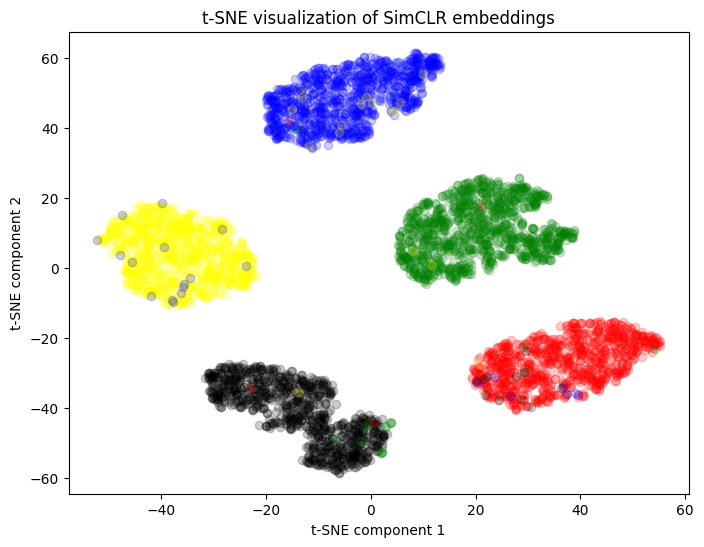

torch.Size([4810, 16])
torch.Size([4810, 16])


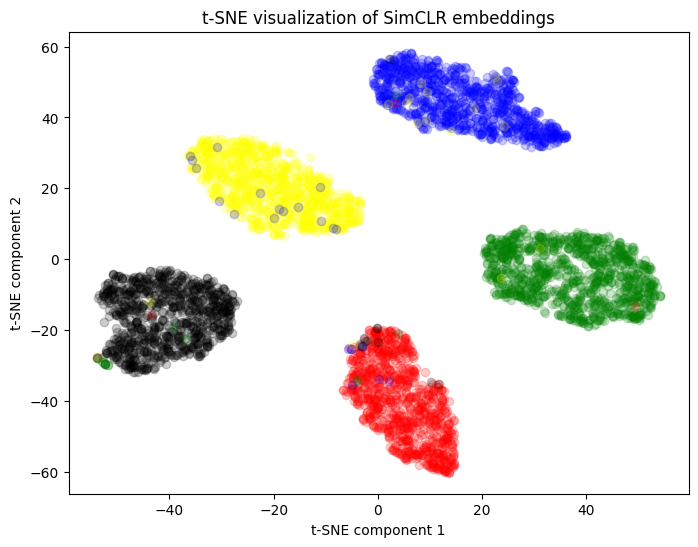

In [ ]:
## update these two as you see fit
curr_model = simclr_model_trained_on_sas_upsampled_50
curr_embedding = simclr_sas_embeddings_upsampled_50

subset_x_for_simclr = [elem[0].to(cpu_device) for elem in sas_subset]
simclr_sas_embeddings_train_upsampled_model = get_simclr_embeddings(curr_model, subset_x_for_simclr)
sas_subset_tsne = get_tsne_embeddings(curr_model, x_embed=curr_embedding.detach(), get_embedding = False)
visualize_tsne_embeddings(sas_subset_tsne, train_label_dict, indices_for_group_partition = sas_subset.subset_indices)


torch.Size([6117, 16])
Epoch 100/100, Loss: 2.036180019378662
Epoch 200/100, Loss: 1.5993539094924927
Epoch 300/100, Loss: 1.4735240936279297
Epoch 400/100, Loss: 1.411873459815979
Epoch 500/100, Loss: 1.3763704299926758
Epoch 600/100, Loss: 1.3527138233184814
Epoch 700/100, Loss: 1.3352940082550049
Epoch 800/100, Loss: 1.3216454982757568
Epoch 900/100, Loss: 1.3105158805847168
Epoch 1000/100, Loss: 1.3011850118637085
Epoch 1100/100, Loss: 1.293200969696045
Epoch 1200/100, Loss: 1.2862606048583984
Epoch 1300/100, Loss: 1.2801486253738403
Epoch 1400/100, Loss: 1.2747026681900024
Epoch 1500/100, Loss: 1.26979398727417
Epoch 1600/100, Loss: 1.2653180360794067
Epoch 1700/100, Loss: 1.2611887454986572
Epoch 1800/100, Loss: 1.2573342323303223
Epoch 1900/100, Loss: 1.2536970376968384
Epoch 2000/100, Loss: 1.2502281665802002
Epoch 2100/100, Loss: 1.2468894720077515
Epoch 2200/100, Loss: 1.2436496019363403
Epoch 2300/100, Loss: 1.2404847145080566
Epoch 2400/100, Loss: 1.2373756170272827
Epoch 2

Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:10,  2.24it/s]

Group (0, 0) Accuracy: 33.16326530612245


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:10,  2.23it/s]

Group (0, 1) Accuracy: 52.04081632653061


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:11,  1.88it/s]

Group (0, 2) Accuracy: 57.142857142857146


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:02<00:12,  1.68it/s]

Group (0, 3) Accuracy: 52.55102040816327


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:02<00:12,  1.57it/s]

Group (0, 4) Accuracy: 51.53061224489796


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:03<00:11,  1.58it/s]

Group (1, 0) Accuracy: 76.65198237885463


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:04<00:11,  1.55it/s]

Group (1, 1) Accuracy: 90.30837004405286


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:04<00:11,  1.50it/s]

Group (1, 2) Accuracy: 92.0704845814978


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:05<00:10,  1.48it/s]

Group (1, 3) Accuracy: 75.33039647577093


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:06<00:10,  1.47it/s]

Group (1, 4) Accuracy: 86.34361233480176


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:06<00:09,  1.49it/s]

Group (2, 0) Accuracy: 31.884057971014492


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:07<00:08,  1.61it/s]

Group (2, 1) Accuracy: 50.72463768115942


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:07<00:06,  1.76it/s]

Group (2, 2) Accuracy: 30.58252427184466


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:08<00:05,  1.90it/s]

Group (2, 3) Accuracy: 47.57281553398058


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:08<00:05,  2.00it/s]

Group (2, 4) Accuracy: 22.815533980582526


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:09<00:04,  2.08it/s]

Group (3, 0) Accuracy: 71.78217821782178


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:09<00:03,  2.15it/s]

Group (3, 1) Accuracy: 67.82178217821782


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:10<00:03,  2.20it/s]

Group (3, 2) Accuracy: 66.83168316831683


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:10<00:02,  2.23it/s]

Group (3, 3) Accuracy: 61.881188118811885


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:10<00:02,  2.23it/s]

Group (3, 4) Accuracy: 72.77227722772277


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:11<00:01,  2.25it/s]

Group (4, 0) Accuracy: 42.63959390862944


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:11<00:01,  2.27it/s]

Group (4, 1) Accuracy: 48.73096446700507


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:12<00:00,  2.27it/s]

Group (4, 2) Accuracy: 57.6530612244898


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:12<00:00,  2.28it/s]

Group (4, 3) Accuracy: 44.38775510204081


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:13<00:00,  1.90it/s]

Group (4, 4) Accuracy: 46.93877551020408
 
average accuracy:  54.204755914680234
worst-group accuracy:  ((2, 4), 22.815533980582526)


{(0, 0): 33.16326530612245,
 (0, 1): 52.04081632653061,
 (0, 2): 57.142857142857146,
 (0, 3): 52.55102040816327,
 (0, 4): 51.53061224489796,
 (1, 0): 76.65198237885463,
 (1, 1): 90.30837004405286,
 (1, 2): 92.0704845814978,
 (1, 3): 75.33039647577093,
 (1, 4): 86.34361233480176,
 (2, 0): 31.884057971014492,
 (2, 1): 50.72463768115942,
 (2, 2): 30.58252427184466,
 (2, 3): 47.57281553398058,
 (2, 4): 22.815533980582526,
 (3, 0): 71.78217821782178,
 (3, 1): 67.82178217821782,
 (3, 2): 66.83168316831683,
 (3, 3): 61.881188118811885,
 (3, 4): 72.77227722772277,
 (4, 0): 42.63959390862944,
 (4, 1): 48.73096446700507,
 (4, 2): 57.6530612244898,
 (4, 3): 44.38775510204081,
 (4, 4): 46.93877551020408}

** Model Overfits to minority groups with upsample factor = 100**

In [ ]:
## update these two as you see fit
curr_model = simclr_model_trained_on_sas_upsampled_20
curr_embedding = simclr_sas_embeddings_upsampled_20

simclr_sas_embeddings_val = get_simclr_embeddings(curr_model, val_set)
linear_classifier_sas = train_linear_classifier(simclr_sas_embeddings_val.detach(), val_clabels, 7500)

simclr_embeddings_test = get_simclr_embeddings(curr_model, test_set)

get_group_wise_accuracy(simclr_embeddings_test,
                    linear_classifier_sas,
                    test_set,
                    curr_trainset)

torch.Size([6117, 16])
Epoch 100/100, Loss: 2.140239715576172
Epoch 200/100, Loss: 1.4312623739242554
Epoch 300/100, Loss: 1.2622594833374023
Epoch 400/100, Loss: 1.1792712211608887
Epoch 500/100, Loss: 1.1251304149627686
Epoch 600/100, Loss: 1.0863876342773438
Epoch 700/100, Loss: 1.0576560497283936
Epoch 800/100, Loss: 1.0358271598815918
Epoch 900/100, Loss: 1.0188450813293457
Epoch 1000/100, Loss: 1.0053050518035889
Epoch 1100/100, Loss: 0.9942434430122375
Epoch 1200/100, Loss: 0.9849995970726013
Epoch 1300/100, Loss: 0.9771170616149902
Epoch 1400/100, Loss: 0.9702771902084351
Epoch 1500/100, Loss: 0.964253306388855
Epoch 1600/100, Loss: 0.9588805437088013
Epoch 1700/100, Loss: 0.954035758972168
Epoch 1800/100, Loss: 0.9496259093284607
Epoch 1900/100, Loss: 0.9455775022506714
Epoch 2000/100, Loss: 0.9418327212333679
Epoch 2100/100, Loss: 0.9383444786071777
Epoch 2200/100, Loss: 0.9350751042366028
Epoch 2300/100, Loss: 0.9319928288459778
Epoch 2400/100, Loss: 0.9290722012519836
Epoch

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([5139, 16])


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:10,  2.23it/s]

Group (0, 0) Accuracy: 53.06122448979592


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:10,  2.26it/s]

Group (0, 1) Accuracy: 64.28571428571429


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:09,  2.28it/s]

Group (0, 2) Accuracy: 63.775510204081634


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:09,  2.28it/s]

Group (0, 3) Accuracy: 71.93877551020408


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:02<00:08,  2.30it/s]

Group (0, 4) Accuracy: 67.85714285714286


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:02<00:08,  2.31it/s]

Group (1, 0) Accuracy: 96.47577092511013


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:03<00:07,  2.31it/s]

Group (1, 1) Accuracy: 83.25991189427313


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:03<00:07,  2.31it/s]

Group (1, 2) Accuracy: 99.55947136563877


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:03<00:06,  2.32it/s]

Group (1, 3) Accuracy: 95.59471365638767


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:04<00:06,  2.32it/s]

Group (1, 4) Accuracy: 96.47577092511013


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:04<00:06,  2.31it/s]

Group (2, 0) Accuracy: 78.26086956521739


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:05<00:05,  2.33it/s]

Group (2, 1) Accuracy: 52.17391304347826


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:05<00:05,  2.28it/s]

Group (2, 2) Accuracy: 68.93203883495146


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:06<00:05,  1.95it/s]

Group (2, 3) Accuracy: 26.699029126213592


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:06<00:05,  1.80it/s]

Group (2, 4) Accuracy: 41.74757281553398


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:07<00:05,  1.69it/s]

Group (3, 0) Accuracy: 54.45544554455446


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:08<00:04,  1.64it/s]

Group (3, 1) Accuracy: 69.3069306930693


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:09<00:04,  1.58it/s]

Group (3, 2) Accuracy: 40.59405940594059


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:09<00:03,  1.56it/s]

Group (3, 3) Accuracy: 43.56435643564357


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:10<00:03,  1.53it/s]

Group (3, 4) Accuracy: 77.22772277227723


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:11<00:02,  1.48it/s]

Group (4, 0) Accuracy: 61.421319796954315


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:11<00:01,  1.50it/s]

Group (4, 1) Accuracy: 68.52791878172589


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:12<00:01,  1.62it/s]

Group (4, 2) Accuracy: 76.53061224489795


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:12<00:00,  1.79it/s]

Group (4, 3) Accuracy: 70.91836734693878


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:13<00:00,  1.91it/s]

Group (4, 4) Accuracy: 69.89795918367346
 
average accuracy:  64.64216982598683
worst-group accuracy:  ((2, 3), 26.699029126213592)


{(0, 0): 53.06122448979592,
 (0, 1): 64.28571428571429,
 (0, 2): 63.775510204081634,
 (0, 3): 71.93877551020408,
 (0, 4): 67.85714285714286,
 (1, 0): 96.47577092511013,
 (1, 1): 83.25991189427313,
 (1, 2): 99.55947136563877,
 (1, 3): 95.59471365638767,
 (1, 4): 96.47577092511013,
 (2, 0): 78.26086956521739,
 (2, 1): 52.17391304347826,
 (2, 2): 68.93203883495146,
 (2, 3): 26.699029126213592,
 (2, 4): 41.74757281553398,
 (3, 0): 54.45544554455446,
 (3, 1): 69.3069306930693,
 (3, 2): 40.59405940594059,
 (3, 3): 43.56435643564357,
 (3, 4): 77.22772277227723,
 (4, 0): 61.421319796954315,
 (4, 1): 68.52791878172589,
 (4, 2): 76.53061224489795,
 (4, 3): 70.91836734693878,
 (4, 4): 69.89795918367346}